### 데이터 전처리
- 이미지, label, segmentation 내 중복 데이터 삭제
- annot box 좌표 outlier 처리 : 나머지 두 박스의 평균으로 대체
- annot box 좌표 1개로 통합 (3개 좌표의 평균) -> 새로운 열 생성
- isProf 열 삭제 (학습에 사용되지 않는 데이터)
- annot 내 faceExp, bg 열 삭제 (faceExp_uploader, bg_uploader로 통일)
- 데이터 증강

In [1]:
import json
import numpy as np
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib import rc
import random

In [2]:
# matplotlib 한글 폰트 깨짐 문제 해결
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
fontprop = fm.FontProperties(fname=font_path)

#### 데이터 불리오기

In [3]:
# 경로 설정

data_path = '/workspace/#Ub370#Uc774#Ud130/Data'

img_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/img/train/'
img_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/img/val/'

json_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/label/train/'
json_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/label/val/'

segment_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/train/'
segment_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/val/'


img_path_train_anger = img_path_train + 'anger/'
img_path_val_anger = img_path_val + 'anger/'

img_path_train_happy = img_path_train + 'happy/'
img_path_val_happy = img_path_val + 'happy/'

img_path_train_panic = img_path_train + 'panic/'
img_path_val_panic = img_path_val + 'panic/'

img_path_train_sadness = img_path_train + 'sadness/'
img_path_val_sadness = img_path_val + 'sadness/'

In [4]:
# 라벨 정보 json 파일 
# json_train_anger, json_train_happy, json_train_panic, json_train_sadness
# json_val_anger, json_val_happy, json_val_panic, json_val_sadness

with open (json_path_train + "train_anger.json", "r", encoding='euc-kr') as f:
    json_train_anger = json.load(f)
with open (json_path_val + "val_anger.json", "r", encoding='euc-kr') as f:
    json_val_anger = json.load(f)

with open (json_path_train + "train_happy.json", "r", encoding='euc-kr') as f:
    json_train_happy = json.load(f)
with open (json_path_val + "val_happy.json", "r", encoding='euc-kr') as f:
    json_val_happy = json.load(f)

with open (json_path_train + "train_panic.json", "r", encoding='euc-kr') as f:
    json_train_panic = json.load(f)
with open (json_path_val + "val_panic.json", "r", encoding='euc-kr') as f:
    json_val_panic = json.load(f)

with open (json_path_train + "train_sadness.json", "r", encoding='euc-kr') as f:
    json_train_sadness = json.load(f)
with open (json_path_val + "val_sadness.json", "r", encoding='euc-kr') as f:
    json_val_sadness = json.load(f)

In [5]:
# Segmentation 정보 npz 파일
# npz_train_anger, npz_train_happy, npz_train_panic, npz_train_sadness
# npz_val_anger, npz_val_happy, npz_val_panic, npz_val_sadness

npz_train_anger = np.load(segment_path_train + 'train_anger.npz')
npz_val_anger = np.load(segment_path_val + 'val_anger.npz')

npz_train_happy = np.load(segment_path_train + 'train_happy.npz')
npz_val_happy = np.load(segment_path_val + 'val_happy.npz')

npz_train_panic = np.load(segment_path_train + 'train_panic.npz')
npz_val_panic = np.load(segment_path_val + 'val_panic.npz')

npz_train_sadness = np.load(segment_path_train + 'train_sadness.npz')
npz_val_sadness = np.load(segment_path_val + 'val_sadness.npz')

#### 데이터 확인
- 각 데이터 동일한지 (이미지 이름으로 비교)
- 중복 데이터 삭제

In [6]:
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

# 폴더 내 이미지 파일 개수 세기
def count_images_in_folder(folder_path):
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_count += 1
    return image_count

# 폴더 내 이미지 파일 이름 수집
def get_image_files_in_folder(folder_path):
    image_files = set()
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_files.add(file)
    return image_files

# JSON 파일 내 이미지 파일 이름 수집
def get_image_files_in_json(json_file):
    json_filenames = [item['filename'] for item in json_file]
    json_filenames = set(json_filenames)
    return json_filenames

# NPZ 파일 내 이미지 파일 이름 수집
def get_image_files_in_npz(npz_file):
    npz_filenames = list(npz_file.keys())
    npz_filenames = set(npz_filenames)
    return npz_filenames

##### Anger (Train, Val)

In [12]:
# Train Anger

# 비교 수행
image_count = count_images_in_folder(img_path_train_anger)
image_files_in_folder = get_image_files_in_folder(img_path_train_anger)
image_files_in_json = get_image_files_in_json(json_train_anger)
image_files_in_npz = get_image_files_in_npz(npz_train_anger)

# 누락된 파일 찾기
common_files = image_files_in_folder & image_files_in_json & image_files_in_npz
only_in_folder = image_files_in_folder - image_files_in_json - image_files_in_npz
only_in_json = image_files_in_json - image_files_in_folder - image_files_in_npz
only_in_npz = image_files_in_npz - image_files_in_folder - image_files_in_json

# 결과 출력
print("Train Anger",'\n') 
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_train_anger)}")
print(f"npz 파일 길이 : {len(npz_train_anger)}")
print()
print(f"공통 파일 개수: {len(common_files)}")
print(f"폴더에만 있는 파일 개수: {len(only_in_folder)}")
print(f"JSON에만 있는 파일 개수: {len(only_in_json)}")
print(f"NPZ에만 있는 파일 개수: {len(only_in_npz)}")


Train Anger 

폴더 내 이미지 파일 개수: 1500
json 파일 길이 : 1500
npz 파일 길이 : 1500

공통 파일 개수: 1500
폴더에만 있는 파일 개수: 0
JSON에만 있는 파일 개수: 0
NPZ에만 있는 파일 개수: 0


In [14]:
# Val Anger

# 비교 수행
image_count = count_images_in_folder(img_path_val_anger)
image_files_in_folder = get_image_files_in_folder(img_path_val_anger)
image_files_in_json = get_image_files_in_json(json_val_anger)
image_files_in_npz = get_image_files_in_npz(npz_val_anger)

# 누락된 파일 찾기
common_files = image_files_in_folder & image_files_in_json & image_files_in_npz
only_in_folder = image_files_in_folder - image_files_in_json - image_files_in_npz
only_in_json = image_files_in_json - image_files_in_folder - image_files_in_npz
only_in_npz = image_files_in_npz - image_files_in_folder - image_files_in_json

# 결과 출력
print("Val Anger","\n") 
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_val_anger)}")
print(f"npz 파일 길이 : {len(npz_val_anger)}")
print()
print(f"공통 파일 개수: {len(common_files)}")
print(f"폴더에만 있는 파일 개수: {len(only_in_folder)}")
print(f"JSON에만 있는 파일 개수: {len(only_in_json)}")
print(f"NPZ에만 있는 파일 개수: {len(only_in_npz)}")

Val Anger 

폴더 내 이미지 파일 개수: 300
json 파일 길이 : 300
npz 파일 길이 : 300

공통 파일 개수: 300
폴더에만 있는 파일 개수: 0
JSON에만 있는 파일 개수: 0
NPZ에만 있는 파일 개수: 0


##### Happy (Train Anger)
- train_happy.npz 파일에서 중복 파일 발견 -> 데이터 동일한지 확인 후 삭제 -> 변경한 데이터 저장 (train_happy_updated.npz)

In [18]:
# Train Happy

# 비교 수행
image_count = count_images_in_folder(img_path_train_happy)
image_files_in_folder = get_image_files_in_folder(img_path_train_happy)
image_files_in_json = get_image_files_in_json(json_train_happy)
image_files_in_npz = get_image_files_in_npz(npz_train_happy)

# 누락된 파일 찾기
common_files = image_files_in_folder & image_files_in_json & image_files_in_npz
only_in_folder = image_files_in_folder - image_files_in_json - image_files_in_npz
only_in_json = image_files_in_json - image_files_in_folder - image_files_in_npz
only_in_npz = image_files_in_npz - image_files_in_folder - image_files_in_json

# 결과 출력
print("Train Happy",'\n') 
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_train_happy)}")
print(f"npz 파일 길이 : {len(npz_train_happy)}")
print()
print(f"공통 파일 개수: {len(common_files)}")
print(f"폴더에만 있는 파일 개수: {len(only_in_folder)}")
print(f"JSON에만 있는 파일 개수: {len(only_in_json)}")
print(f"NPZ에만 있는 파일 개수: {len(only_in_npz)}")

Train Happy 

폴더 내 이미지 파일 개수: 1494
json 파일 길이 : 1494
npz 파일 길이 : 1495

공통 파일 개수: 1494
폴더에만 있는 파일 개수: 0
JSON에만 있는 파일 개수: 0
NPZ에만 있는 파일 개수: 1


In [16]:
only_in_npz

{'7jwq74bb4b3a43774918b7c1179842dcb78434458957168835d61bf57c44b5bw8(1).jpg'}

In [17]:
key_to_check_1 = '7jwq74bb4b3a43774918b7c1179842dcb78434458957168835d61bf57c44b5bw8(1).jpg'
key_to_check_2 = '7jwq74bb4b3a43774918b7c1179842dcb78434458957168835d61bf57c44b5bw8.jpg'

# if key_to_check_1 in npz_happy:
#     print(f"Data for key '{key_to_check_1}':")
#     print(npz_happy[key_to_check_1].shape)
#     print(npz_happy[key_to_check_1])
# else:
#     print(f"Key '{key_to_check_1}' not found in the npz file.")

# if key_to_check_2 in npz_happy:
#     print(f"Data for key '{key_to_check_2}':")
#     print(npz_happy[key_to_check_2].shape)
#     print(npz_happy[key_to_check_2])
# else:
#     print(f"Key '{key_to_check_2}' not found in the npz file.")

data1 = npz_train_happy[key_to_check_1]
data2 = npz_train_happy[key_to_check_2]

# 데이터 비교
if np.array_equal(data1, data2):
    print(f"The data for '{key_to_check_1}' and '{key_to_check_2}' are identical.")
else:
    print(f"The data for '{key_to_check_1}' and '{key_to_check_2}' are different.")

The data for '7jwq74bb4b3a43774918b7c1179842dcb78434458957168835d61bf57c44b5bw8(1).jpg' and '7jwq74bb4b3a43774918b7c1179842dcb78434458957168835d61bf57c44b5bw8.jpg' are identical.


In [19]:
# 겹치는 데이터 삭제 & 저장

key_to_delete = key_to_check_1

updated_data = {key: npz_train_happy[key] for key in npz_train_happy.keys() if key != key_to_delete}

combined_npz_path = segment_path_train + 'train_happy_updated.npz'
np.savez_compressed(combined_npz_path, **updated_data)

npz_train_happy = np.load(segment_path_train + 'train_happy_updated.npz')

In [20]:
# 수정된 파일로 다시 확인

# 비교 수행
image_count = count_images_in_folder(img_path_train_happy)
image_files_in_folder = get_image_files_in_folder(img_path_train_happy)
image_files_in_json = get_image_files_in_json(json_train_happy)
image_files_in_npz = get_image_files_in_npz(npz_train_happy)

# 누락된 파일 찾기
common_files = image_files_in_folder & image_files_in_json & image_files_in_npz
only_in_folder = image_files_in_folder - image_files_in_json - image_files_in_npz
only_in_json = image_files_in_json - image_files_in_folder - image_files_in_npz
only_in_npz = image_files_in_npz - image_files_in_folder - image_files_in_json

# 결과 출력
print("Train Happy",'\n') 
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_train_happy)}")
print(f"npz 파일 길이 : {len(npz_train_happy)}")
print()
print(f"공통 파일 개수: {len(common_files)}")
print(f"폴더에만 있는 파일 개수: {len(only_in_folder)}")
print(f"JSON에만 있는 파일 개수: {len(only_in_json)}")
print(f"NPZ에만 있는 파일 개수: {len(only_in_npz)}")

Train Happy 

폴더 내 이미지 파일 개수: 1494
json 파일 길이 : 1494
npz 파일 길이 : 1494

공통 파일 개수: 1494
폴더에만 있는 파일 개수: 0
JSON에만 있는 파일 개수: 0
NPZ에만 있는 파일 개수: 0


In [25]:
# Val Happy

# 비교 수행
image_count = count_images_in_folder(img_path_val_happy)
image_files_in_folder = get_image_files_in_folder(img_path_val_happy)
image_files_in_json = get_image_files_in_json(json_val_happy)
image_files_in_npz = get_image_files_in_npz(npz_val_happy)

# 누락된 파일 찾기
common_files = image_files_in_folder & image_files_in_json & image_files_in_npz
only_in_folder = image_files_in_folder - image_files_in_json - image_files_in_npz
only_in_json = image_files_in_json - image_files_in_folder - image_files_in_npz
only_in_npz = image_files_in_npz - image_files_in_folder - image_files_in_json

# 결과 출력
print("Val Happy",'\n') 
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_val_happy)}")
print(f"npz 파일 길이 : {len(npz_val_happy)}")
print()
print(f"공통 파일 개수: {len(common_files)}")
print(f"폴더에만 있는 파일 개수: {len(only_in_folder)}")
print(f"JSON에만 있는 파일 개수: {len(only_in_json)}")
print(f"NPZ에만 있는 파일 개수: {len(only_in_npz)}")

Val Happy 

폴더 내 이미지 파일 개수: 300
json 파일 길이 : 300
npz 파일 길이 : 300

공통 파일 개수: 300
폴더에만 있는 파일 개수: 0
JSON에만 있는 파일 개수: 0
NPZ에만 있는 파일 개수: 0


##### Panic (Train, Val)
- train_panic.npz 파일에서 중복 파일 발견 -> 데이터 동일한지 확인 후 삭제 -> 변경한 데이터 저장 (train_panic_updated.npz)

In [29]:
# Train Panic

# 비교 수행
image_count = count_images_in_folder(img_path_train_panic)
image_files_in_folder = get_image_files_in_folder(img_path_train_panic)
image_files_in_json = get_image_files_in_json(json_train_panic)
image_files_in_npz = get_image_files_in_npz(npz_train_panic)

# 누락된 파일 찾기
common_files = image_files_in_folder & image_files_in_json & image_files_in_npz
only_in_folder = image_files_in_folder - image_files_in_json - image_files_in_npz
only_in_json = image_files_in_json - image_files_in_folder - image_files_in_npz
only_in_npz = image_files_in_npz - image_files_in_folder - image_files_in_json

# 결과 출력
print("Train Panic",'\n') 
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_train_panic)}")
print(f"npz 파일 길이 : {len(npz_train_panic)}")
print()
print(f"공통 파일 개수: {len(common_files)}")
print(f"폴더에만 있는 파일 개수: {len(only_in_folder)}")
print(f"JSON에만 있는 파일 개수: {len(only_in_json)}")
print(f"NPZ에만 있는 파일 개수: {len(only_in_npz)}")

Train Panic 

폴더 내 이미지 파일 개수: 1500
json 파일 길이 : 1500
npz 파일 길이 : 1501

공통 파일 개수: 1500
폴더에만 있는 파일 개수: 0
JSON에만 있는 파일 개수: 0
NPZ에만 있는 파일 개수: 1


In [27]:
only_in_npz

{'64f21a1de3537ea5e57bfcf0195951512db6f5def5575b49eb7eea785bb25emqj(1).jpg'}

In [28]:
key_to_check_1 = '64f21a1de3537ea5e57bfcf0195951512db6f5def5575b49eb7eea785bb25emqj(1).jpg'
key_to_check_2 = '64f21a1de3537ea5e57bfcf0195951512db6f5def5575b49eb7eea785bb25emqj.jpg'

# if key_to_check_1 in npz_happy:
#     print(f"Data for key '{key_to_check_1}':")
#     print(npz_happy[key_to_check_1].shape)
#     print(npz_happy[key_to_check_1])
# else:
#     print(f"Key '{key_to_check_1}' not found in the npz file.")

# if key_to_check_2 in npz_happy:
#     print(f"Data for key '{key_to_check_2}':")
#     print(npz_happy[key_to_check_2].shape)
#     print(npz_happy[key_to_check_2])
# else:
#     print(f"Key '{key_to_check_2}' not found in the npz file.")

data1 = npz_train_panic[key_to_check_1]
data2 = npz_train_panic[key_to_check_2]

# 데이터 비교
if np.array_equal(data1, data2):
    print(f"The data for '{key_to_check_1}' and '{key_to_check_2}' are identical.")
else:
    print(f"The data for '{key_to_check_1}' and '{key_to_check_2}' are different.")

The data for '64f21a1de3537ea5e57bfcf0195951512db6f5def5575b49eb7eea785bb25emqj(1).jpg' and '64f21a1de3537ea5e57bfcf0195951512db6f5def5575b49eb7eea785bb25emqj.jpg' are identical.


In [30]:
# 겹치는 데이터 삭제 & 저장

key_to_delete = key_to_check_1

updated_data = {key: npz_train_panic[key] for key in npz_train_panic.keys() if key != key_to_delete}

combined_npz_path = segment_path_train + 'train_panic_updated.npz'
np.savez_compressed(combined_npz_path, **updated_data)

npz_train_panic = np.load(segment_path_train + 'train_panic_updated.npz')

In [31]:
# 수정된 파일로 다시 확인

# 비교 수행
image_count = count_images_in_folder(img_path_train_panic)
image_files_in_folder = get_image_files_in_folder(img_path_train_panic)
image_files_in_json = get_image_files_in_json(json_train_panic)
image_files_in_npz = get_image_files_in_npz(npz_train_panic)

# 누락된 파일 찾기
common_files = image_files_in_folder & image_files_in_json & image_files_in_npz
only_in_folder = image_files_in_folder - image_files_in_json - image_files_in_npz
only_in_json = image_files_in_json - image_files_in_folder - image_files_in_npz
only_in_npz = image_files_in_npz - image_files_in_folder - image_files_in_json

# 결과 출력
print("Train Panic",'\n') 
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_train_panic)}")
print(f"npz 파일 길이 : {len(npz_train_panic)}")
print()
print(f"공통 파일 개수: {len(common_files)}")
print(f"폴더에만 있는 파일 개수: {len(only_in_folder)}")
print(f"JSON에만 있는 파일 개수: {len(only_in_json)}")
print(f"NPZ에만 있는 파일 개수: {len(only_in_npz)}")

Train Panic 

폴더 내 이미지 파일 개수: 1500
json 파일 길이 : 1500
npz 파일 길이 : 1500

공통 파일 개수: 1500
폴더에만 있는 파일 개수: 0
JSON에만 있는 파일 개수: 0
NPZ에만 있는 파일 개수: 0


In [32]:
# Val Panic

# 비교 수행
image_count = count_images_in_folder(img_path_val_panic)
image_files_in_folder = get_image_files_in_folder(img_path_val_panic)
image_files_in_json = get_image_files_in_json(json_val_panic)
image_files_in_npz = get_image_files_in_npz(npz_val_panic)

# 누락된 파일 찾기
common_files = image_files_in_folder & image_files_in_json & image_files_in_npz
only_in_folder = image_files_in_folder - image_files_in_json - image_files_in_npz
only_in_json = image_files_in_json - image_files_in_folder - image_files_in_npz
only_in_npz = image_files_in_npz - image_files_in_folder - image_files_in_json

# 결과 출력
print("Val Panic",'\n') 
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_val_panic)}")
print(f"npz 파일 길이 : {len(npz_val_panic)}")
print()
print(f"공통 파일 개수: {len(common_files)}")
print(f"폴더에만 있는 파일 개수: {len(only_in_folder)}")
print(f"JSON에만 있는 파일 개수: {len(only_in_json)}")
print(f"NPZ에만 있는 파일 개수: {len(only_in_npz)}")

Val Panic 

폴더 내 이미지 파일 개수: 300
json 파일 길이 : 300
npz 파일 길이 : 300

공통 파일 개수: 300
폴더에만 있는 파일 개수: 0
JSON에만 있는 파일 개수: 0
NPZ에만 있는 파일 개수: 0


##### Sadness (Train, Val)

In [33]:
# Train Sadness

# 비교 수행
image_count = count_images_in_folder(img_path_train_sadness)
image_files_in_folder = get_image_files_in_folder(img_path_train_sadness)
image_files_in_json = get_image_files_in_json(json_train_sadness)
image_files_in_npz = get_image_files_in_npz(npz_train_sadness)

# 누락된 파일 찾기
common_files = image_files_in_folder & image_files_in_json & image_files_in_npz
only_in_folder = image_files_in_folder - image_files_in_json - image_files_in_npz
only_in_json = image_files_in_json - image_files_in_folder - image_files_in_npz
only_in_npz = image_files_in_npz - image_files_in_folder - image_files_in_json

# 결과 출력
print("Train Sadness",'\n') 
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_train_sadness)}")
print(f"npz 파일 길이 : {len(npz_train_sadness)}")
print()
print(f"공통 파일 개수: {len(common_files)}")
print(f"폴더에만 있는 파일 개수: {len(only_in_folder)}")
print(f"JSON에만 있는 파일 개수: {len(only_in_json)}")
print(f"NPZ에만 있는 파일 개수: {len(only_in_npz)}")

Train Sadness 

폴더 내 이미지 파일 개수: 1500
json 파일 길이 : 1500
npz 파일 길이 : 1500

공통 파일 개수: 1500
폴더에만 있는 파일 개수: 0
JSON에만 있는 파일 개수: 0
NPZ에만 있는 파일 개수: 0


In [34]:
# Val Sadness

# 비교 수행
image_count = count_images_in_folder(img_path_val_sadness)
image_files_in_folder = get_image_files_in_folder(img_path_val_sadness)
image_files_in_json = get_image_files_in_json(json_val_sadness)
image_files_in_npz = get_image_files_in_npz(npz_val_sadness)

# 누락된 파일 찾기
common_files = image_files_in_folder & image_files_in_json & image_files_in_npz
only_in_folder = image_files_in_folder - image_files_in_json - image_files_in_npz
only_in_json = image_files_in_json - image_files_in_folder - image_files_in_npz
only_in_npz = image_files_in_npz - image_files_in_folder - image_files_in_json

# 결과 출력
print("Val Sadness",'\n') 
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_val_sadness)}")
print(f"npz 파일 길이 : {len(npz_val_sadness)}")
print()
print(f"공통 파일 개수: {len(common_files)}")
print(f"폴더에만 있는 파일 개수: {len(only_in_folder)}")
print(f"JSON에만 있는 파일 개수: {len(only_in_json)}")
print(f"NPZ에만 있는 파일 개수: {len(only_in_npz)}")

Val Sadness 

폴더 내 이미지 파일 개수: 300
json 파일 길이 : 300
npz 파일 길이 : 300

공통 파일 개수: 300
폴더에만 있는 파일 개수: 0
JSON에만 있는 파일 개수: 0
NPZ에만 있는 파일 개수: 0


#### Label (json 파일) 전처리
- json 파일 dataframe으로 변환
- isProf 열 삭제 (학습에 사용되지 않는 데이터)
- annot 내 faceExp, bg 열 삭제 (faceExp_uploader, bg_uploader로 통일)
- annot box 좌표 outlier 처리 : 나머지 두 박스의 평균으로 대체
- annot box 좌표 1개로 통합 (3개 좌표의 평균) -> 새로운 열 생성


In [71]:
# Json 파일 -> DataFrame 변환
# df_train_anger, df_train_happy, df_train_panic, df_train_sadness
# df_val_anger, df_val_happy, df_val_panic, df_val_sadness

# 데이터프레임 생성
df_train_anger = pd.json_normalize(json_train_anger)
df_val_anger = pd.json_normalize(json_val_anger)

df_train_happy = pd.json_normalize(json_train_happy)
df_val_happy = pd.json_normalize(json_val_happy)

df_train_panic = pd.json_normalize(json_train_panic)
df_val_panic = pd.json_normalize(json_val_panic)

df_train_sadness = pd.json_normalize(json_train_sadness)
df_val_sadness = pd.json_normalize(json_val_sadness)

In [72]:
df_train_anger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   filename            1500 non-null   object 
 1   gender              1500 non-null   object 
 2   age                 1500 non-null   int64  
 3   isProf              1500 non-null   object 
 4   faceExp_uploader    1500 non-null   object 
 5   bg_uploader         1500 non-null   object 
 6   annot_A.boxes.maxX  1500 non-null   float64
 7   annot_A.boxes.maxY  1500 non-null   float64
 8   annot_A.boxes.minX  1500 non-null   float64
 9   annot_A.boxes.minY  1500 non-null   float64
 10  annot_A.faceExp     1500 non-null   object 
 11  annot_A.bg          1500 non-null   object 
 12  annot_B.boxes.maxX  1500 non-null   float64
 13  annot_B.boxes.maxY  1500 non-null   float64
 14  annot_B.boxes.minX  1500 non-null   float64
 15  annot_B.boxes.minY  1500 non-null   float64
 16  annot_

In [73]:
df_train_anger

filename gender  age isProf  \
0     6oj439e3fbcc52759fb3093035b7c0ecc55c93543dae63...      남   30    일반인   
1     65rsfe402042f34319e10128c1ab9614e2f967690a64a0...      남   40    전문인   
2     b1cbe34734870cc11c33334e02bea93ac3a3b061caab62...      여   20    전문인   
3     llfycc0aa29599cc63cace3610fdaaad3a99aab2ee38c9...      여   50    일반인   
4     3hww73b70615461a7336d0383b53582f8bf804f6e0f30d...      여   30    일반인   
...                                                 ...    ...  ...    ...   
1495  2tby14ba67fea06c15c1c19c15c47b0a7c90bbe3f06076...      여   40    전문인   
1496  6io429357a004d6e9d9858e9c97c993a78633403434364...      여   40    일반인   
1497  0tj25997789690fd794f341e6a4a67e36010101688bef0...      남   20    일반인   
1498  88oia7ac423f30f3767186eca94cc04702847519a7c16a...      여   20    일반인   
1499  kwo3ff0f613a3d10de39c62d6afed70c2ca9c6fe1dc378...      남   30    전문인   

     faceExp_uploader        bg_uploader  annot_A.boxes.maxX  \
0                  분노  교통/이동수단(엘리베이터 포함)         2073.254605   
1                  분노          문화재 및 유적지         2889.526926   
2                  분노            오락/공연시설         1950.380119   
3                  분노       공공시설/종교/의료시설          849.400700   
4                  분노         상업시설/점포/시장         1402.888900   
...               ...                ...                 ...   
1495               분노            실외 자연환경         2075.192400   
1496               분노          숙박 및 거주공간         1952.873800   
1497               분노         상업시설/점포/시장         1814.245700   
1498               분노  교통/이동수단(엘리베이터 포함)         1764.386826   
1499               분노              도심 환경         1810.692143   

      annot_A.boxes.maxY  annot_A.boxes.minX  annot_A.boxes.minY  ...  \
0            1486.204442         1338.220105          539.506642  ...   
1            2306.348256         1812.222817          711.278453  ...   
2            1564.586938         1092.901126          565.437117  ...   
3            1153.137300          156.987700          289.183000  ...   
4            1383.816300          614.351500          295.559080  ...   
...                  ...                 ...                 ...  ...   
1495         1604.840914         1316.008500          515.588943  ...   
1496         1483.373900         1305.516800          605.378800  ...   
1497         1223.343500         1032.791900          265.025760  ...   
1498         1143.669262         1094.868224          219.091746  ...   
1499         1651.235196          880.070201          372.811888  ...   

     annot_B.boxes.minX annot_B.boxes.minY  annot_B.faceExp  \
0           1341.270105         528.132642               분노   
1           1816.913391         688.002830               분노   
2           1011.849151         395.670259               불안   
3            138.103869         316.337158               분노   
4            622.707997         301.142264               분노   
...                 ...                ...              ...   
1495        1298.760133         490.733934               슬픔   
1496        1276.334089         573.419268               분노   
1497        1012.609221         346.446889               분노   
1498        1086.115200         239.490170               불안   
1499         866.405365         356.502016               불안   

             annot_B.bg  annot_C.boxes.maxX  annot_C.boxes.maxY  \
0     교통/이동수단(엘리베이터 포함)         2072.188605         1487.918442   
1            공공시설/종교/의료         2902.734100         2300.207800   
2                 도심 환경         1953.119000         1569.929200   
3            공공시설/종교/의료          849.400700         1153.137300   
4               오락/공연시설         1402.888900         1383.816300   
...                 ...                 ...                 ...   
1495            실외 자연환경         2075.161049         1604.844543   
1496          숙박 및 거주공간         1952.873800         1483.373900   
1497         상업시설/점포/시장         1841.184517         1316.857067   
1498  교통/이동수단(엘리베이터 포함)         1779.

##### Column 제거
- isProf 열 삭제 (학습에 사용되지 않는 데이터)
- annot 내 faceExp, bg 열 삭제 (faceExp_uploader, bg_uploader로 통일)

In [74]:
# 제거할 열 리스트
columns_to_drop = [
    'isProf', 
    'annot_A.faceExp', 'annot_A.bg', 
    'annot_B.faceExp', 'annot_B.bg', 
    'annot_C.faceExp', 'annot_C.bg'
    ]

# column 제거
df_train_anger = df_train_anger.drop(columns=columns_to_drop)
df_val_anger = df_val_anger.drop(columns=columns_to_drop)

df_train_happy = df_train_happy.drop(columns=columns_to_drop)
df_val_happy = df_val_happy.drop(columns=columns_to_drop)

df_train_panic = df_train_panic.drop(columns=columns_to_drop)
df_val_panic = df_val_panic.drop(columns=columns_to_drop)

df_train_sadness = df_train_sadness.drop(columns=columns_to_drop)
df_val_sadness = df_val_sadness.drop(columns=columns_to_drop)


In [75]:
df_train_anger

filename gender  age  \
0     6oj439e3fbcc52759fb3093035b7c0ecc55c93543dae63...      남   30   
1     65rsfe402042f34319e10128c1ab9614e2f967690a64a0...      남   40   
2     b1cbe34734870cc11c33334e02bea93ac3a3b061caab62...      여   20   
3     llfycc0aa29599cc63cace3610fdaaad3a99aab2ee38c9...      여   50   
4     3hww73b70615461a7336d0383b53582f8bf804f6e0f30d...      여   30   
...                                                 ...    ...  ...   
1495  2tby14ba67fea06c15c1c19c15c47b0a7c90bbe3f06076...      여   40   
1496  6io429357a004d6e9d9858e9c97c993a78633403434364...      여   40   
1497  0tj25997789690fd794f341e6a4a67e36010101688bef0...      남   20   
1498  88oia7ac423f30f3767186eca94cc04702847519a7c16a...      여   20   
1499  kwo3ff0f613a3d10de39c62d6afed70c2ca9c6fe1dc378...      남   30   

     faceExp_uploader        bg_uploader  annot_A.boxes.maxX  \
0                  분노  교통/이동수단(엘리베이터 포함)         2073.254605   
1                  분노          문화재 및 유적지         2889.526926   
2                  분노            오락/공연시설         1950.380119   
3                  분노       공공시설/종교/의료시설          849.400700   
4                  분노         상업시설/점포/시장         1402.888900   
...               ...                ...                 ...   
1495               분노            실외 자연환경         2075.192400   
1496               분노          숙박 및 거주공간         1952.873800   
1497               분노         상업시설/점포/시장         1814.245700   
1498               분노  교통/이동수단(엘리베이터 포함)         1764.386826   
1499               분노              도심 환경         1810.692143   

      annot_A.boxes.maxY  annot_A.boxes.minX  annot_A.boxes.minY  \
0            1486.204442         1338.220105          539.506642   
1            2306.348256         1812.222817          711.278453   
2            1564.586938         1092.901126          565.437117   
3            1153.137300          156.987700          289.183000   
4            1383.816300          614.351500          295.559080   
...                  ...                 ...                 ...   
1495         1604.840914         1316.008500          515.588943   
1496         1483.373900         1305.516800          605.378800   
1497         1223.343500         1032.791900          265.025760   
1498         1143.669262         1094.868224          219.091746   
1499         1651.235196          880.070201          372.811888   

      annot_B.boxes.maxX  annot_B.boxes.maxY  annot_B.boxes.minX  \
0            2074.663605         1490.044442         1341.270105   
1            2875.110464         2311.339041         1816.913391   
2            2036.463513         1572.633082         1011.849151   
3             868.284531         1180.291458          138.103869   
4            1405.700576         1389.399484          622.707997   
...                  ...                 ...                 ...   
1495         2082.025672         1615.138192         1298.760133   
1496         1947.452385         1451.414368         1276.334089   
1497         1840.243955         1304.764629         1012.609221   
1498         1779.042200         1090.823700         1086.115200   
1499         1820.077641         1646.159980          866.405365   

      annot_B.boxes.minY  annot_C.boxes.maxX  annot_C.boxes.maxY  \
0             528.132642         2072.188605         1487.918442   
1             688.002830         2902.734100         2300.207800   
2             395.670259         1953.119000         1569.929200   
3             316.337158          849.400700         1153.137300   
4             301.142264         1402.888900         1383.816300   
...                  ...                 ...                 ...   
1495          490.733934         2075.161049         1604.844543   
1496          573.419268         1952.873800         1483.373900   
1497          346.446889         1841.184517         1316.857067   
1498          239.490170         1779.042200         1090.823700   
1499          356.502016         1775.61840

##### Outlier 확인
- 시각화 후 확인 -> 객체(얼굴) 범위를 벗어난 데이터 확인

In [39]:
# 박스 A,B,C의 좌표 차이가 일정 수치 이상인 데이터 검출

# 차이 확인 함수
def is_significant_difference(boxA, boxB, boxC, threshold):
    def box_difference(box1, box2):
        return sum(abs(box1[key] - box2[key]) for key in box1)
    
    diff_AB = box_difference(boxA, boxB)
    diff_BC = box_difference(boxB, boxC)
    diff_CA = box_difference(boxC, boxA)
    
    return max(diff_AB, diff_BC, diff_CA) > threshold


# outlier 데이터 추출 (json)
def extract_outliers(data):
    outlier_filenames = []

    for entry in data:
        annot_A = entry['annot_A']['boxes']
        annot_B = entry['annot_B']['boxes']
        annot_C = entry['annot_C']['boxes']
    
        if is_significant_difference(annot_A, annot_B, annot_C, thershold):
            outlier_filenames.append(entry['filename'])

    print(f"outlier 파일 수:{len(outlier_filenames)}")

    return [entry for entry in data if entry['filename'] in outlier_filenames]

# outlier_json_ = extract_outliers(json_)



In [40]:
# outlier 시각화

# 이미지,박스 시각화 함수 정의
def visualize_boxes(data, image_dir):
    # data = data[:10]  # 30개 이미지만 시각화
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.ravel()

    for idx, item in enumerate(data):
        filename = item['filename']
        image_path = os.path.join(image_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image {filename} not found in directory {image_dir}.")
            continue

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image) 
        axes[idx].axis('off')

        # Plot boxes from annotations
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            if annot_key in item:
                box = item[annot_key]['boxes']
                x = [box['minX'], box['maxX'], box['maxX'], box['minX'], box['minX']]
                y = [box['minY'], box['minY'], box['maxY'], box['maxY'], box['minY']]
                axes[idx].plot(x, y, label=annot_key)

        axes[idx].set_title(filename[:10], fontsize=8)
        axes[idx].legend(fontsize=6)
       
    # Hide unused subplots
    for i in range(len(data), 10):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
visualize_boxes(outlier_json_, img_path_)


In [41]:
# outlier 데이터 좌표 출력

def format_boxes(box):
    return {key: round(value, 2) for key, value in box.items()}

def print_outlier_coordinates(outlier_data):
    for i, entry in enumerate(outlier_data):
        print(f"Outlier {i+1}:")
        print(f"Filename: {entry['filename']}")
        print(f"  annot_A: {format_boxes(entry['annot_A']['boxes'])}")
        print(f"  annot_B: {format_boxes(entry['annot_B']['boxes'])}")
        print(f"  annot_C: {format_boxes(entry['annot_C']['boxes'])}")
        print("-" * 50)

print_outlier_coordinates(outlier_json_)

In [ ]:
thershold = 500

outlier 파일 수:4


Invalid SOS parameters for sequential JPEG


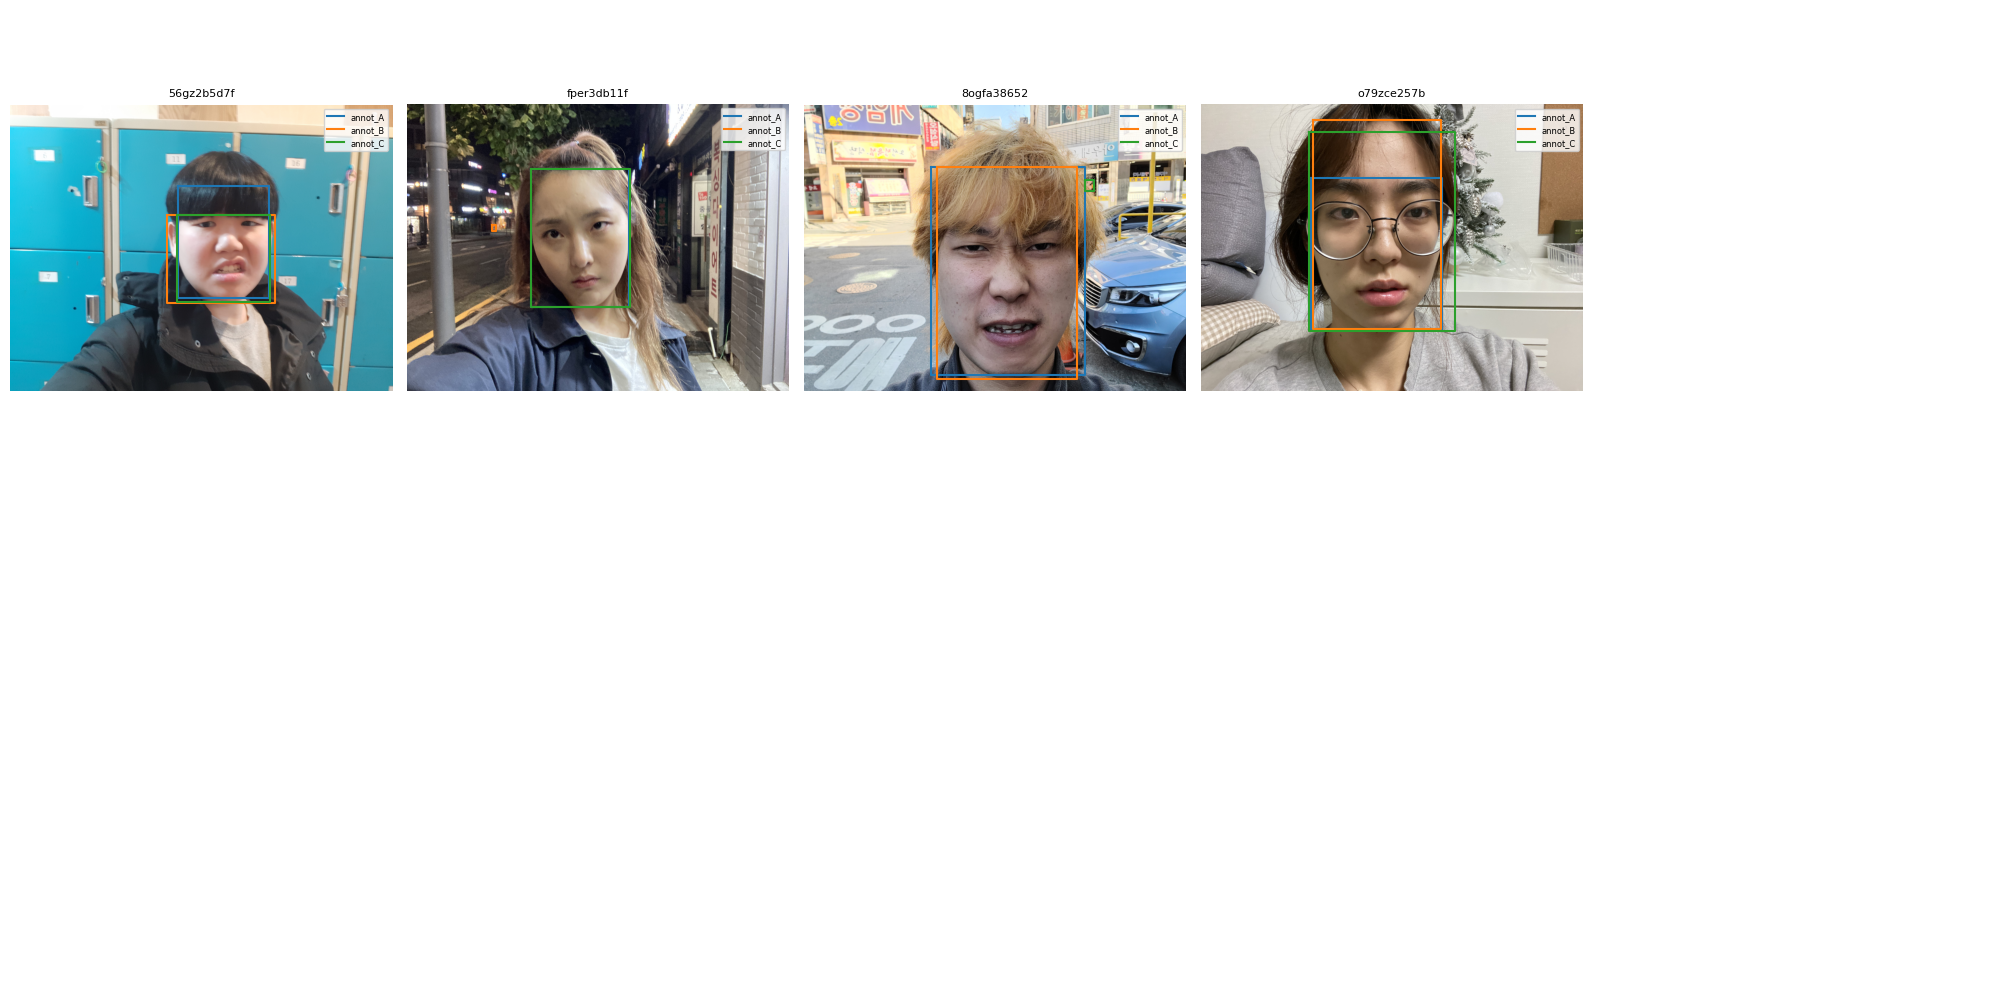

Outlier 1:
Filename: 56gz2b5d7f85e5224f8c4b8ca22b822cc74684a2623cccac4ecaefa1e3a5aj5op.jpg
  annot_A: {'maxX': 3122.28, 'maxY': 2335.06, 'minX': 2028.43, 'minY': 976.63}
  annot_B: {'maxX': 3196.46, 'maxY': 2390.17, 'minX': 1887.59, 'minY': 1330.05}
  annot_C: {'maxX': 3137.42, 'maxY': 2376.91, 'minX': 2018.38, 'minY': 1336.84}
--------------------------------------------------
Outlier 2:
Filename: fper3db11fef98f236117e11df9f5ad4a93e1c9bf2172b1fa9bf41e47f2b17siz.jpg
  annot_A: {'maxX': 1795.42, 'maxY': 1639.41, 'minX': 1004.0, 'minY': 519.08}
  annot_B: {'maxX': 715.29, 'maxY': 1025.97, 'minX': 682.77, 'minY': 978.44}
  annot_C: {'maxX': 1801.49, 'maxY': 1639.29, 'minX': 1000.98, 'minY': 523.62}
--------------------------------------------------
Outlier 3:
Filename: 8ogfa38652ea8c683e6e77ce6a635a586dec07484a7a8428ed5ba78e3d22cjubb.jpg
  annot_A: {'maxX': 2165.36, 'maxY': 2084.8, 'minX': 975.41, 'minY': 484.28}
  annot_B: {'maxX': 2106.81, 'maxY': 2117.52, 'minX': 1020.82, 'minY': 484.

In [42]:
# Train Anger
outlier_json_train_anger = extract_outliers(json_train_anger)
visualize_boxes(outlier_json_train_anger, img_path_train_anger)
print_outlier_coordinates(outlier_json_train_anger)

outlier 파일 수:1


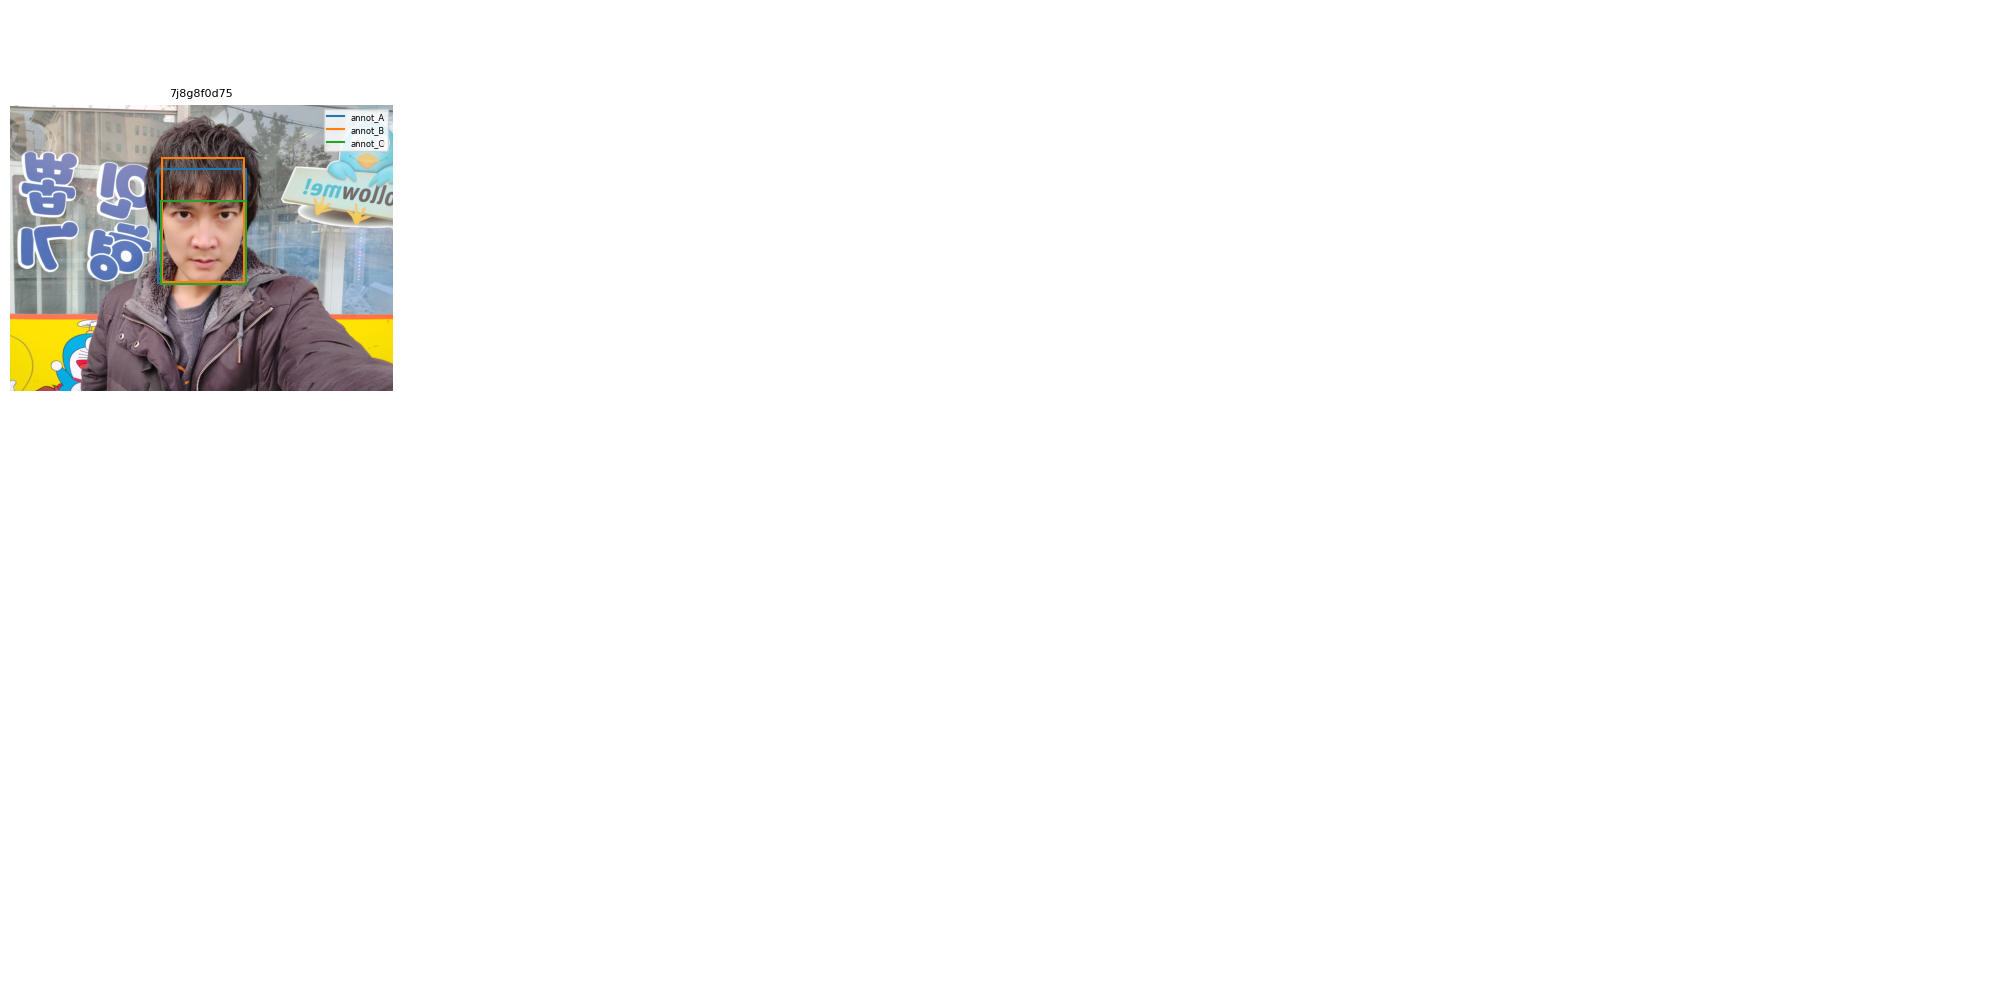

Outlier 1:
Filename: 7j8g8f0d75c68c342c387887740d7289102d87973b36373669c4794a481d6ot2w.jpg
  annot_A: {'maxX': 2851.52, 'maxY': 2152.7, 'minX': 1788.57, 'minY': 772.41}
  annot_B: {'maxX': 2822.49, 'maxY': 2142.04, 'minX': 1827.4, 'minY': 646.6}
  annot_C: {'maxX': 2840.48, 'maxY': 2168.1, 'minX': 1818.5, 'minY': 1169.25}
--------------------------------------------------


In [43]:
# Val  Anger
outlier_json_val_anger = extract_outliers(json_val_anger)
visualize_boxes(outlier_json_val_anger, img_path_val_anger)
print_outlier_coordinates(outlier_json_val_anger)

outlier 파일 수:6


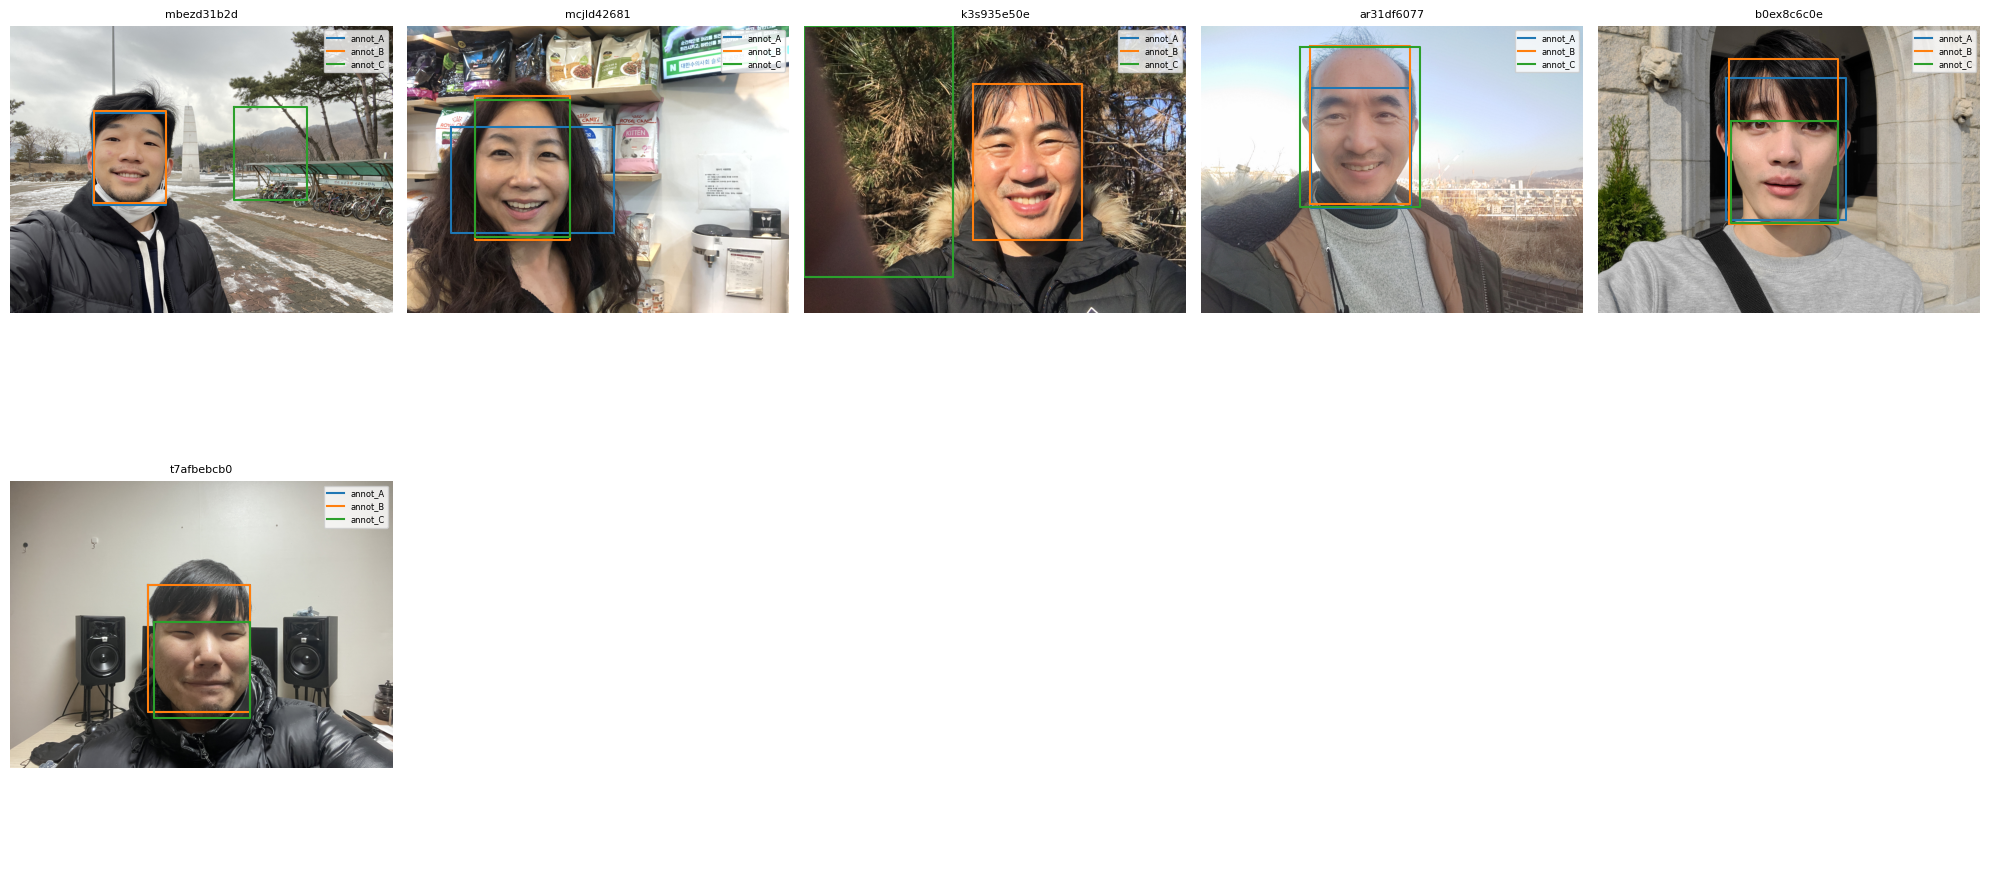

Outlier 1:
Filename: mbezd31b2d54ff4cc87290207fbe33ee4a7afe5344a788fe87cbce4fb8b1c4y2l.jpg
  annot_A: {'maxX': 1651.18, 'maxY': 1889.88, 'minX': 876.66, 'minY': 914.05}
  annot_B: {'maxX': 1646.67, 'maxY': 1867.8, 'minX': 882.99, 'minY': 891.98}
  annot_C: {'maxX': 3137.66, 'maxY': 1831.33, 'minX': 2363.14, 'minY': 855.5}
--------------------------------------------------
Outlier 2:
Filename: mcjld42681ab084d7243371ac8345626dc48d6b2615aa8804b573cbc74e4fw7x2.jpg
  annot_A: {'maxX': 1669.7, 'maxY': 1676.98, 'minX': 353.75, 'minY': 819.65}
  annot_B: {'maxX': 1319.11, 'maxY': 1726.24, 'minX': 550.93, 'minY': 568.48}
  annot_C: {'maxX': 1319.11, 'maxY': 1706.61, 'minX': 550.93, 'minY': 600.47}
--------------------------------------------------
Outlier 3:
Filename: k3s935e50e666fee414ce63c6a7cc0563dbee792014b083a74cbcbf602b735rqt.jpg
  annot_A: {'maxX': 1004.93, 'maxY': 1691.06, 'minX': 0, 'minY': 0}
  annot_B: {'maxX': 1877.13, 'maxY': 1443.41, 'minX': 1137.49, 'minY': 391.83}
  annot_C: {

In [44]:
# Train Happy
outlier_json_train_happy = extract_outliers(json_train_happy)
visualize_boxes(outlier_json_train_happy, img_path_train_happy)
print_outlier_coordinates(outlier_json_train_happy)

outlier 파일 수:2


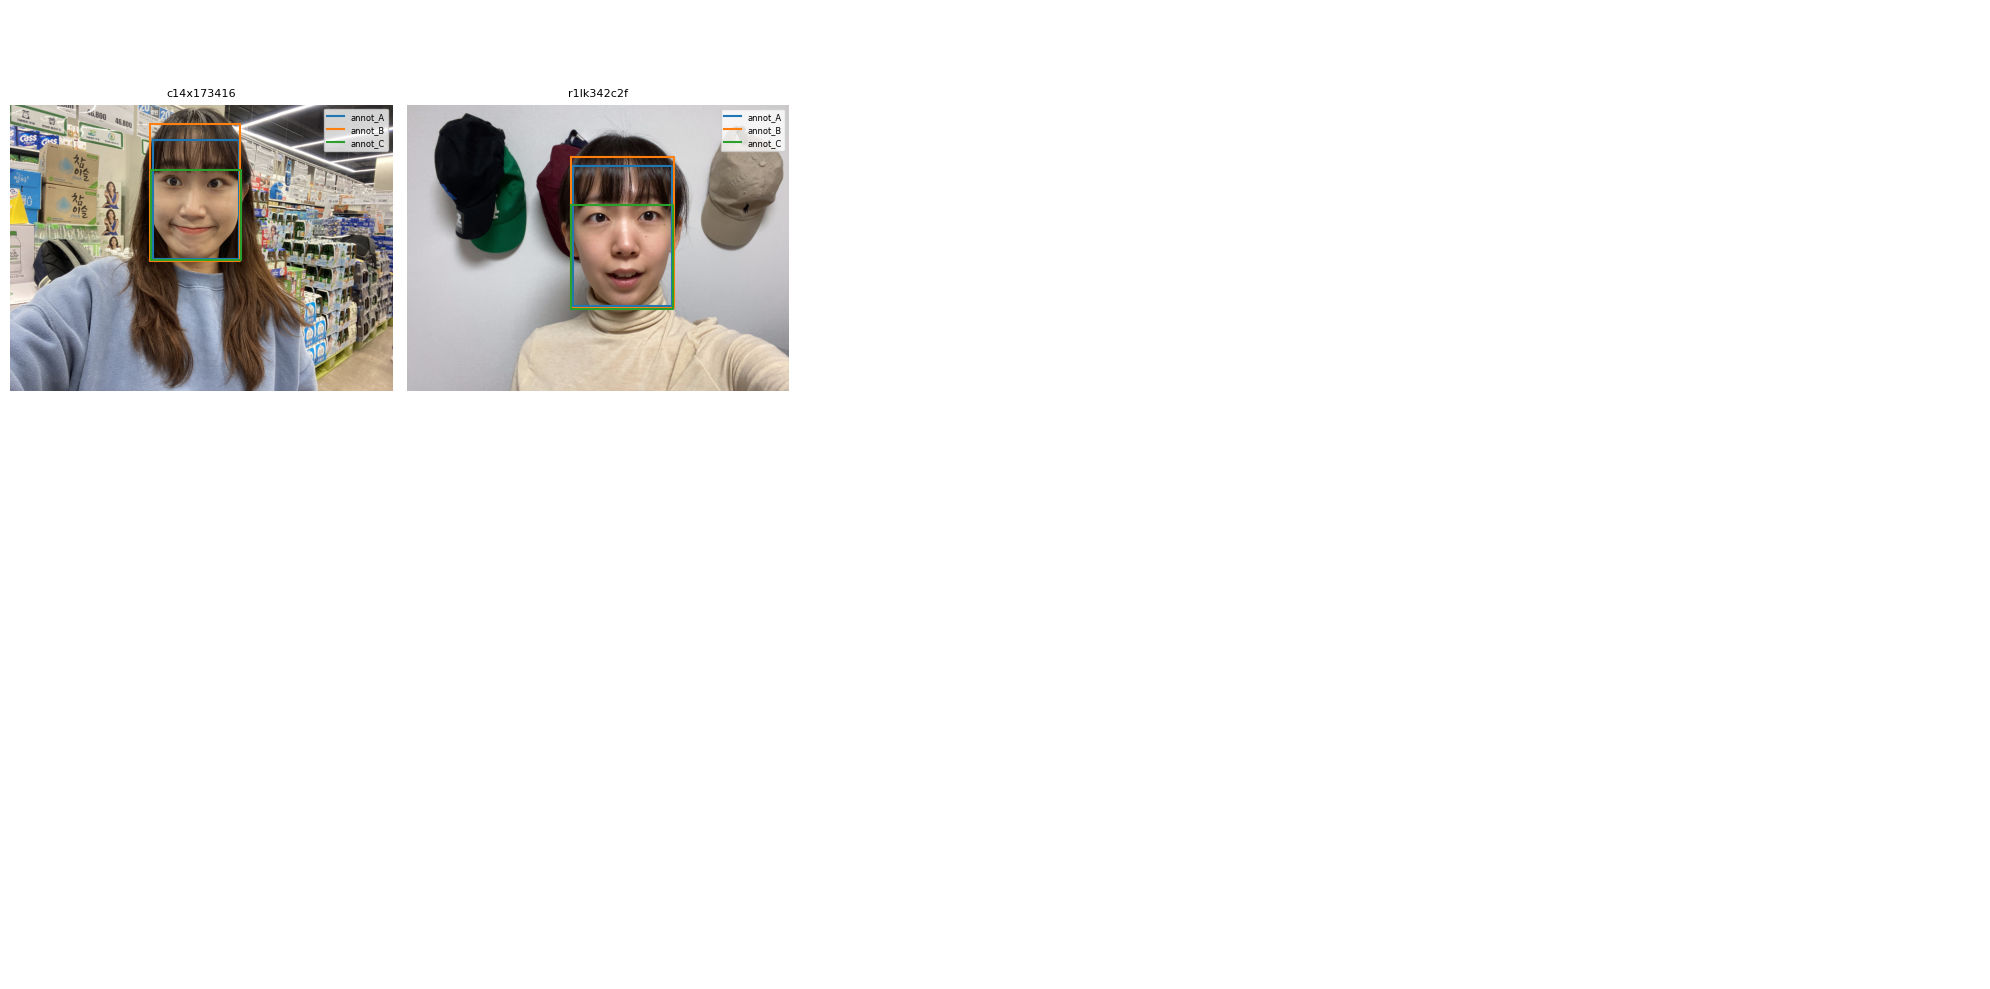

Outlier 1:
Filename: c14x173416131f1933ad3acae3631d6a1b34b131c1b3f21f19dc3981922ee63x6.jpg
  annot_A: {'maxX': 2417.03, 'maxY': 1625.11, 'minX': 1505.17, 'minY': 373.12}
  annot_B: {'maxX': 2427.48, 'maxY': 1647.78, 'minX': 1478.14, 'minY': 206.2}
  annot_C: {'maxX': 2437.59, 'maxY': 1637.39, 'minX': 1489.43, 'minY': 690.04}
--------------------------------------------------
Outlier 2:
Filename: r1lk342c2f445128a53e3eb7ba024e7d5b97e5eb4c269e65ea748e7277167wftm.jpg
  annot_A: {'maxX': 2801.68, 'maxY': 2128.01, 'minX': 1754.55, 'minY': 649.88}
  annot_B: {'maxX': 2816.78, 'maxY': 2150.25, 'minX': 1728.5, 'minY': 549.04}
  annot_C: {'maxX': 2809.51, 'maxY': 2160.85, 'minX': 1726.83, 'minY': 1058.69}
--------------------------------------------------


In [45]:
# Val Happy
outlier_json_val_happy = extract_outliers(json_val_happy)
visualize_boxes(outlier_json_val_happy, img_path_val_happy)
print_outlier_coordinates(outlier_json_val_happy)

outlier 파일 수:3


Invalid SOS parameters for sequential JPEG


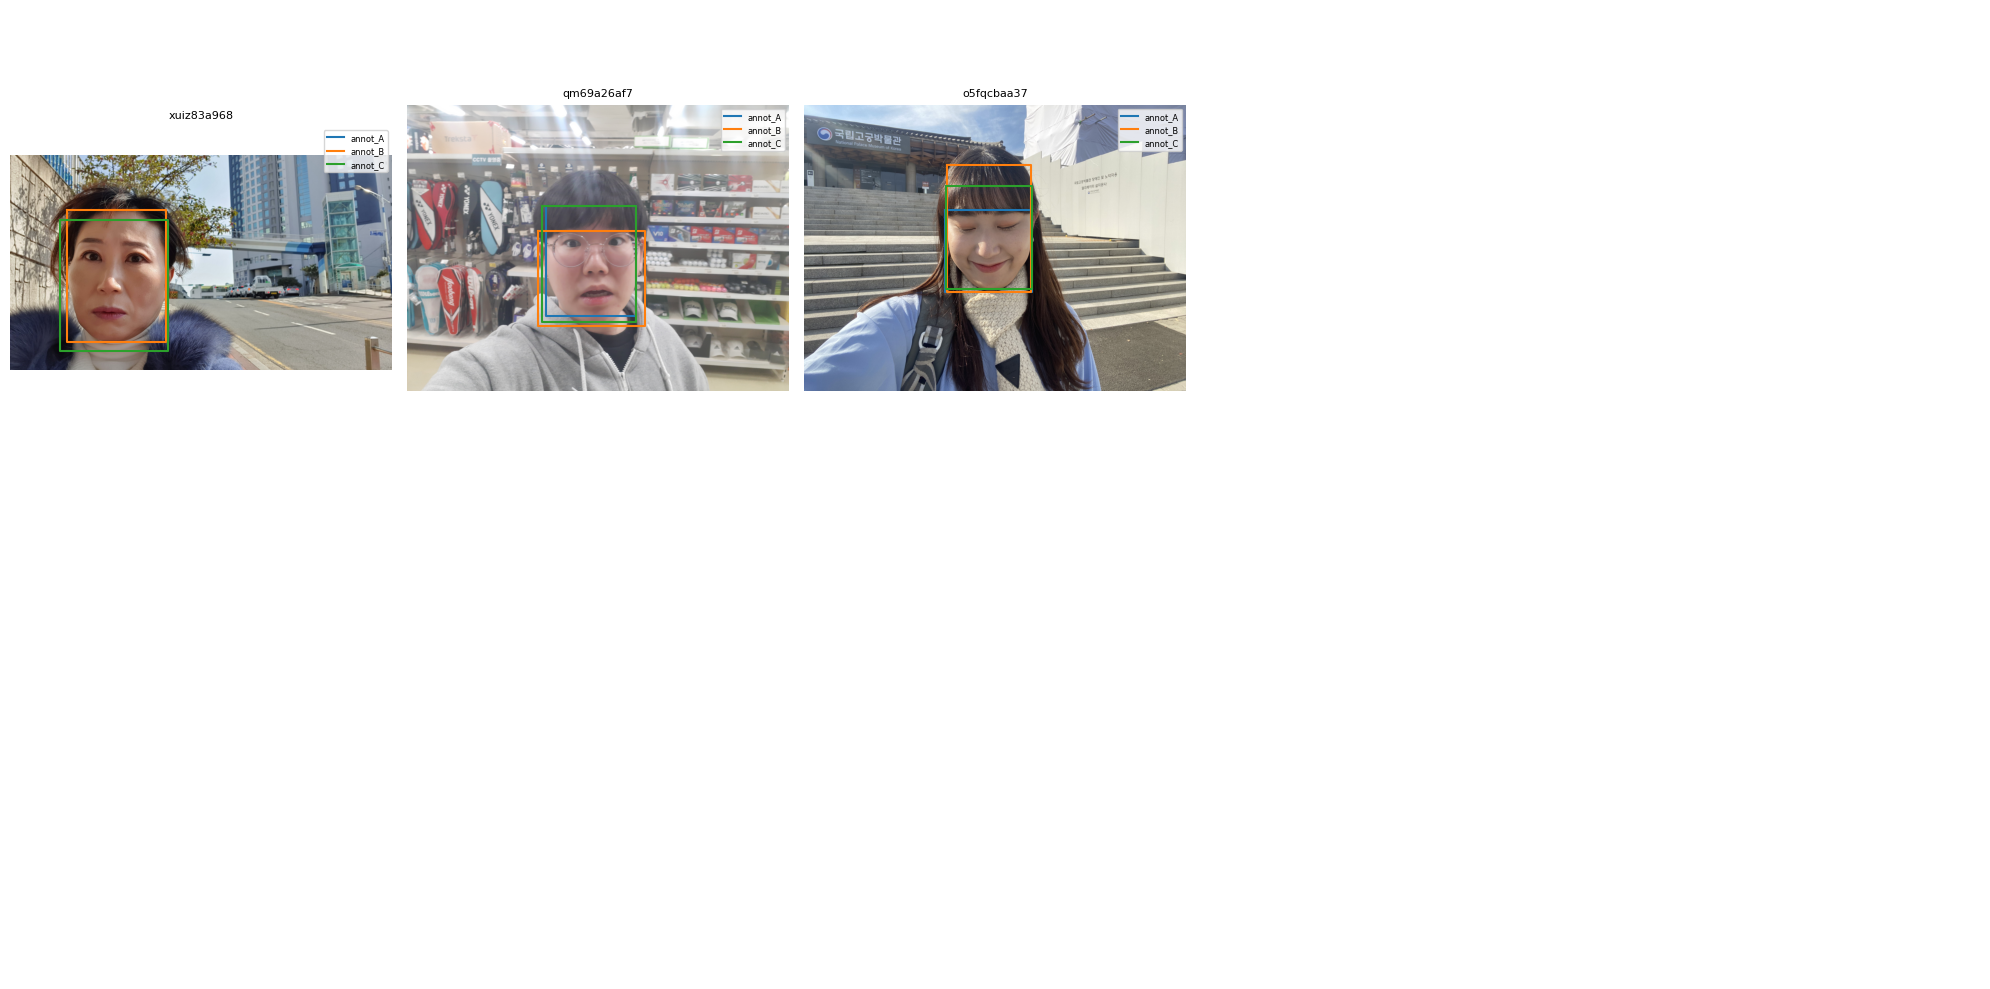

Outlier 1:
Filename: xuiz83a96877b841898d16f32a9276e7a8d779d8d68f458e2816e296d6558w6em.jpg
  annot_A: {'maxX': 0, 'maxY': -146.85, 'minX': 0, 'minY': -146.85}
  annot_B: {'maxX': 1313.98, 'maxY': 1572.79, 'minX': 482.65, 'minY': 459.74}
  annot_C: {'maxX': 1326.96, 'maxY': 1646.84, 'minX': 417.85, 'minY': 545.1}
--------------------------------------------------
Outlier 2:
Filename: qm69a26af73232c7cde3b4233338b325218c82eea2e2cc80563e264beccd5m5on.jpg
  annot_A: {'maxX': 2765.61, 'maxY': 2551.82, 'minX': 1679.9, 'minY': 1222.02}
  annot_B: {'maxX': 2873.13, 'maxY': 2666.79, 'minX': 1579.06, 'minY': 1529.98}
  annot_C: {'maxX': 2765.39, 'maxY': 2620.15, 'minX': 1632.63, 'minY': 1222.28}
--------------------------------------------------
Outlier 3:
Filename: o5fqcbaa37a381ba1930720956a1611910f2c1aaa7f937afdf0abe43a3ef5ynti.jpg
  annot_A: {'maxX': 2404.47, 'maxY': 1975.13, 'minX': 1490.06, 'minY': 1114.67}
  annot_B: {'maxX': 2396.05, 'maxY': 1977.3, 'minX': 1508.95, 'minY': 640.52}
  ann

In [46]:
# Train Panic
outlier_json_train_panic = extract_outliers(json_train_panic)
visualize_boxes(outlier_json_train_panic, img_path_train_panic)
print_outlier_coordinates(outlier_json_train_panic)

outlier 파일 수:2


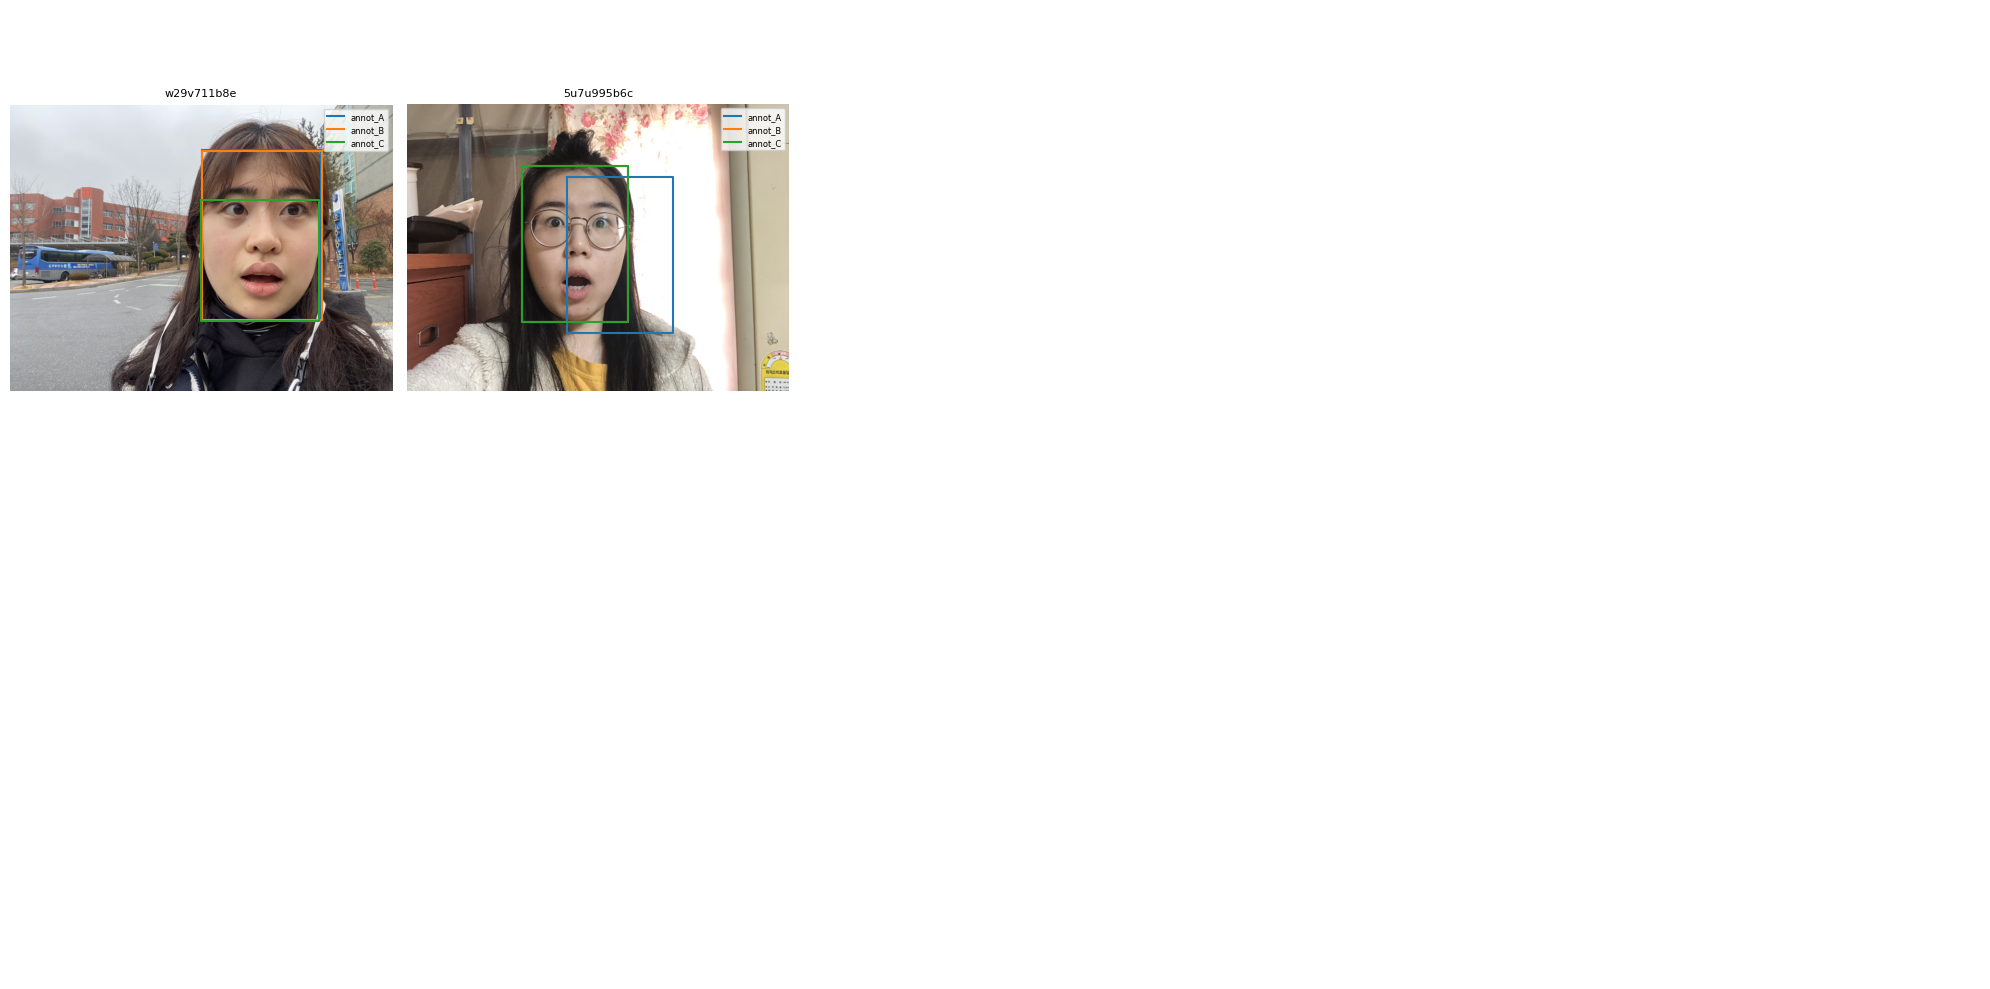

Outlier 1:
Filename: w29v711b8e595b16be3990c859815fe7b6ee0c1110c1121771a06a0127925fowx.jpg
  annot_A: {'maxX': 3279.49, 'maxY': 2278.89, 'minX': 2021.51, 'minY': 479.0}
  annot_B: {'maxX': 3296.18, 'maxY': 2277.98, 'minX': 2020.79, 'minY': 485.6}
  annot_C: {'maxX': 3260.47, 'maxY': 2289.46, 'minX': 2016.71, 'minY': 1012.11}
--------------------------------------------------
Outlier 2:
Filename: 5u7u995b6cf179cc54e768ef75255576d22747468cd2fc94ff31cbe2fc677bmok.jpg
  annot_A: {'maxX': 2152.53, 'maxY': 1848.75, 'minX': 1292.49, 'minY': 590.74}
  annot_B: {'maxX': 1786.52, 'maxY': 1760.46, 'minX': 926.48, 'minY': 502.45}
  annot_C: {'maxX': 1786.52, 'maxY': 1760.46, 'minX': 926.48, 'minY': 502.45}
--------------------------------------------------


In [47]:
# Val Panic
outlier_json_val_panic = extract_outliers(json_val_panic)
visualize_boxes(outlier_json_val_panic, img_path_val_panic)
print_outlier_coordinates(outlier_json_val_panic)

outlier 파일 수:4


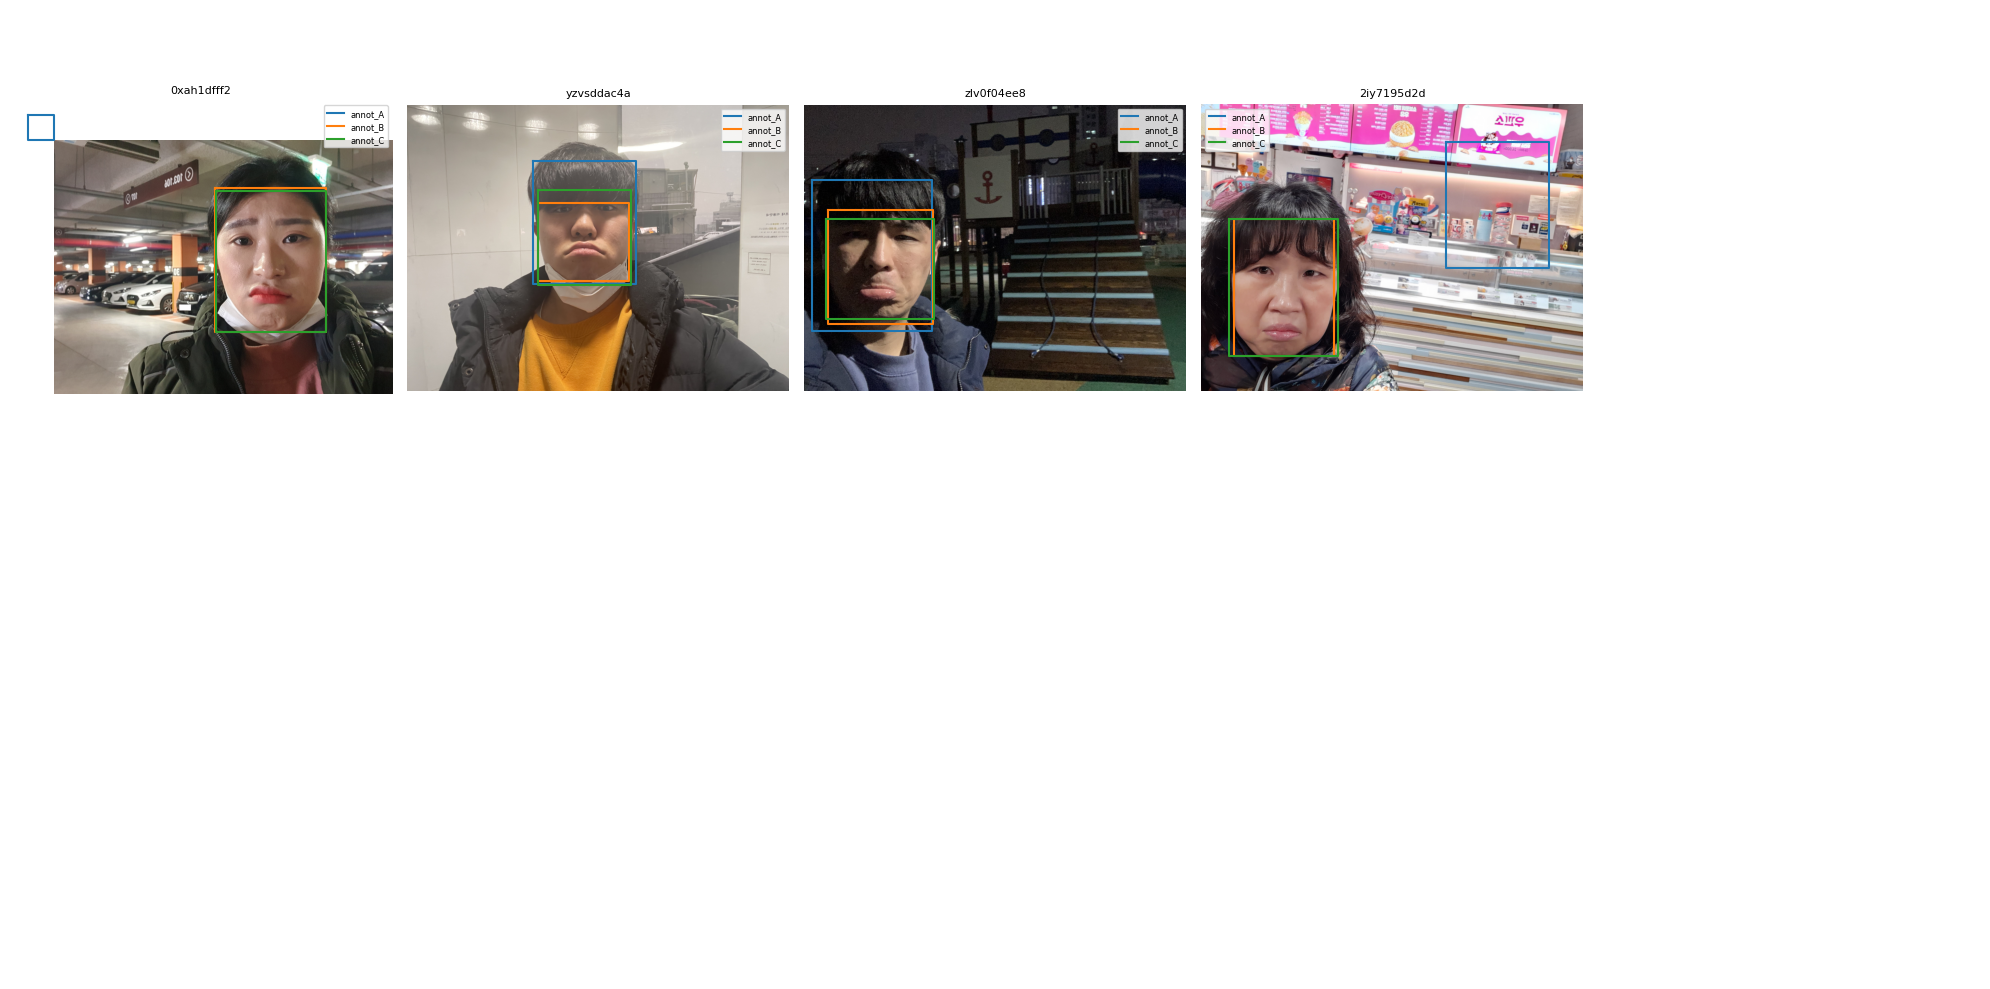

Outlier 1:
Filename: 0xah1dfff2988dd0bb1002299e49a2e81221721df2086792404682f191894jnl2.jpg
  annot_A: {'maxX': 0, 'maxY': 0, 'minX': -221.24, 'minY': -219.05}
  annot_B: {'maxX': 2369.76, 'maxY': 1668.09, 'minX': 1407.36, 'minY': 414.56}
  annot_C: {'maxX': 2367.09, 'maxY': 1663.46, 'minX': 1411.49, 'minY': 435.68}
--------------------------------------------------
Outlier 2:
Filename: yzvsddac4a0d3d5fca4399b4cb5c9174204b560155f724cbd520e271422d4z2mb.jpg
  annot_A: {'maxX': 2412.6, 'maxY': 1892.16, 'minX': 1330.3, 'minY': 593.6}
  annot_B: {'maxX': 2345.07, 'maxY': 1862.63, 'minX': 1387.34, 'minY': 1037.16}
  annot_C: {'maxX': 2364.46, 'maxY': 1904.19, 'minX': 1380.74, 'minY': 899.33}
--------------------------------------------------
Outlier 3:
Filename: zlv0f04ee8afdbd37afcb9a39f404043fac43dc76fd6357c67ac421764624tjjy.jpg
  annot_A: {'maxX': 1035.94, 'maxY': 1834.16, 'minX': 65.93, 'minY': 606.67}
  annot_B: {'maxX': 1044.66, 'maxY': 1770.62, 'minX': 191.24, 'minY': 854.59}
  annot_C

In [48]:
# Train Sadness
outlier_json_train_sadness = extract_outliers(json_train_sadness)
visualize_boxes(outlier_json_train_sadness, img_path_train_sadness)
print_outlier_coordinates(outlier_json_train_sadness)

outlier 파일 수:1


Invalid SOS parameters for sequential JPEG


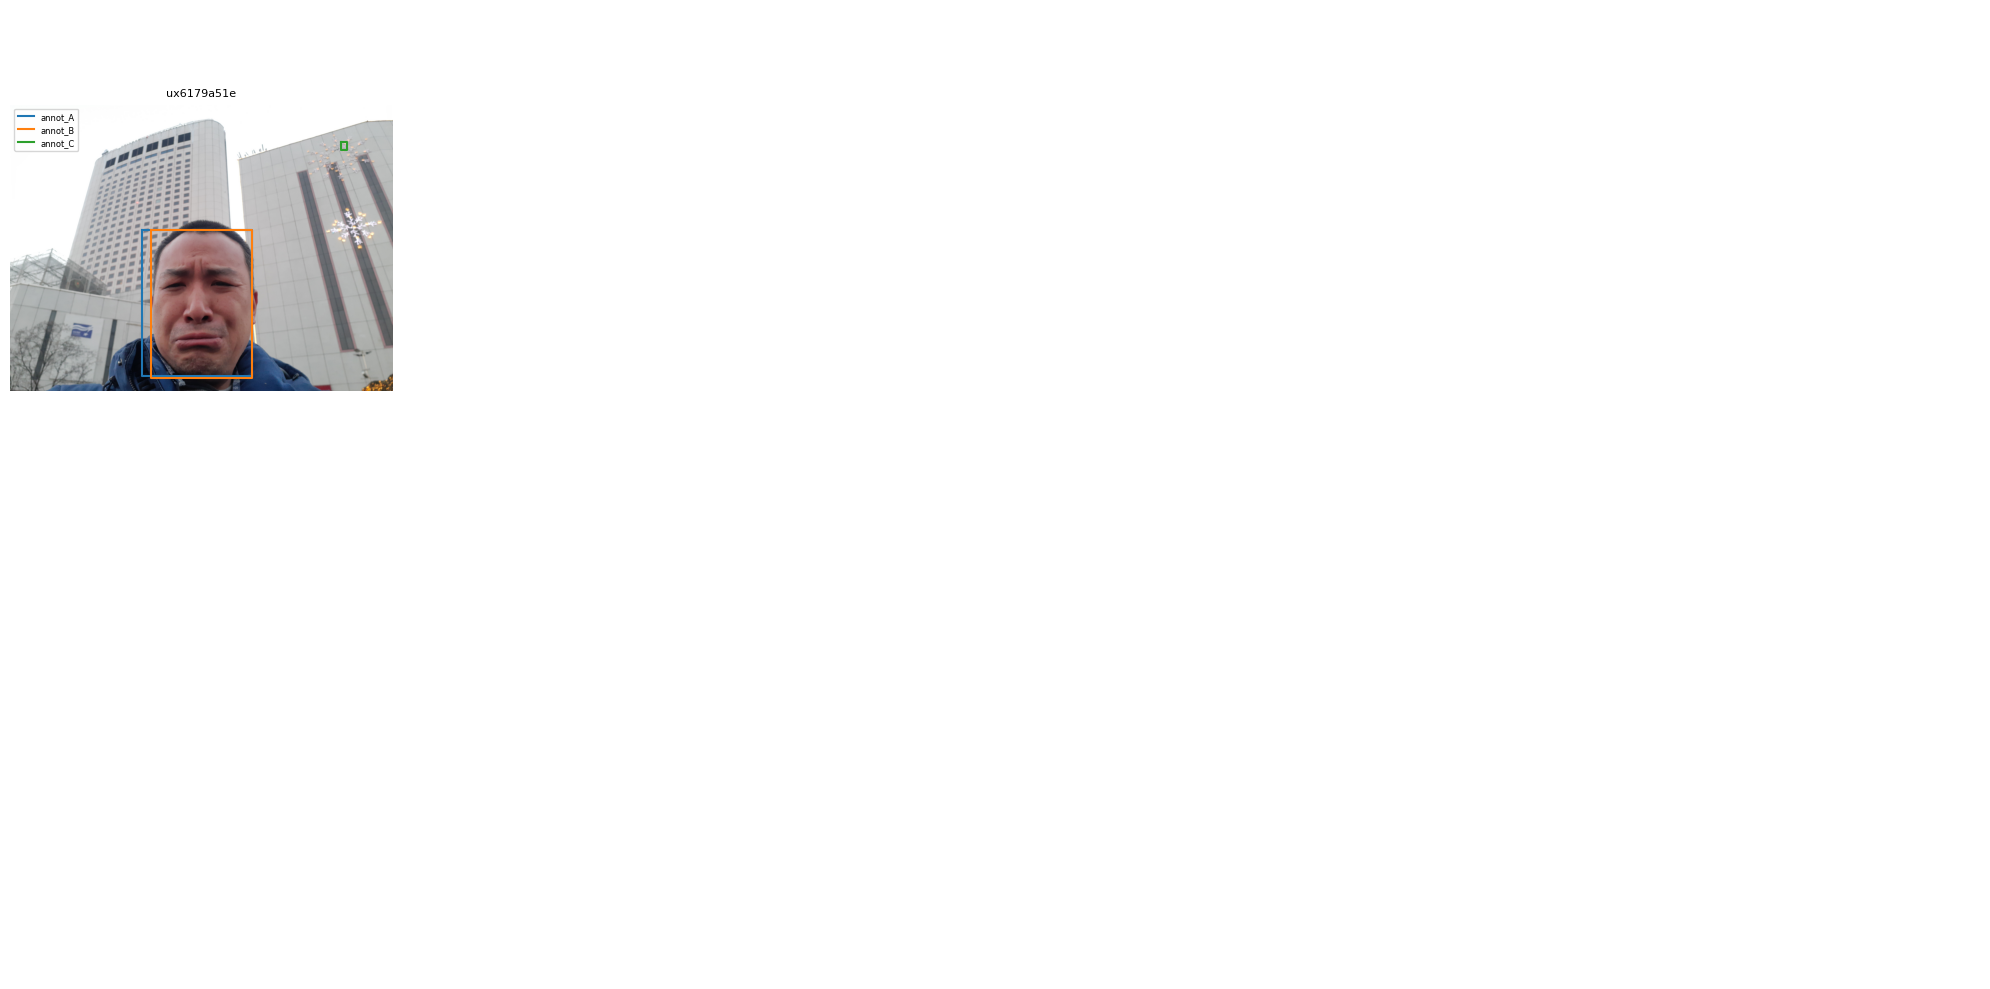

Outlier 1:
Filename: ux6179a51e510953512d0c60796936550d4e2f94d929f1c415e900e095e95hl9z.jpg
  annot_A: {'maxX': 2924, 'maxY': 3280.11, 'minX': 1587.06, 'minY': 1516.4}
  annot_B: {'maxX': 2924.61, 'maxY': 3302.31, 'minX': 1697.92, 'minY': 1516.49}
  annot_C: {'maxX': 4067.54, 'maxY': 545.04, 'minX': 3992.24, 'minY': 456.12}
--------------------------------------------------


In [49]:
# Val Sadness
outlier_json_val_sadness = extract_outliers(json_val_sadness)
visualize_boxes(outlier_json_val_sadness, img_path_val_sadness)
print_outlier_coordinates(outlier_json_val_sadness)

##### Outlier 제거
- Outlier 데이터의 해당 박스 좌표 다른 박스들의 평균값으로 대체

In [76]:
# Train Anger (df_train_anger)

# fper3db11fef98f236117e11df9f5ad4a93e1c9bf2172b1fa9bf41e47f2b17siz.jpg : B 박스 좌표 수정
target_filename_1 = "fper3db11fef98f236117e11df9f5ad4a93e1c9bf2172b1fa9bf41e47f2b17siz.jpg"
if target_filename_1 in df_train_anger["filename"].values:
    idx_1 = df_train_anger["filename"] == target_filename_1
    df_train_anger.loc[idx_1, "annot_B.boxes.maxX"] = df_train_anger.loc[idx_1, ["annot_A.boxes.maxX", "annot_C.boxes.maxX"]].mean(axis=1)
    df_train_anger.loc[idx_1, "annot_B.boxes.maxY"] = df_train_anger.loc[idx_1, ["annot_A.boxes.maxY", "annot_C.boxes.maxY"]].mean(axis=1)
    df_train_anger.loc[idx_1, "annot_B.boxes.minX"] = df_train_anger.loc[idx_1, ["annot_A.boxes.minX", "annot_C.boxes.minX"]].mean(axis=1)
    df_train_anger.loc[idx_1, "annot_B.boxes.minY"] = df_train_anger.loc[idx_1, ["annot_A.boxes.minY", "annot_C.boxes.minY"]].mean(axis=1)

# 8ogfa38652ea8c683e6e77ce6a635a586dec07484a7a8428ed5ba78e3d22cjubb.jpg : C 박스 좌표 수정
target_filename_2 = "8ogfa38652ea8c683e6e77ce6a635a586dec07484a7a8428ed5ba78e3d22cjubb.jpg"
if target_filename_2 in df_train_anger["filename"].values:
    idx_2 = df_train_anger["filename"] == target_filename_2
    df_train_anger.loc[idx_2, "annot_C.boxes.maxX"] = df_train_anger.loc[idx_2, ["annot_A.boxes.maxX", "annot_B.boxes.maxX"]].mean(axis=1)
    df_train_anger.loc[idx_2, "annot_C.boxes.maxY"] = df_train_anger.loc[idx_2, ["annot_A.boxes.maxY", "annot_B.boxes.maxY"]].mean(axis=1)
    df_train_anger.loc[idx_2, "annot_C.boxes.minX"] = df_train_anger.loc[idx_2, ["annot_A.boxes.minX", "annot_B.boxes.minX"]].mean(axis=1)
    df_train_anger.loc[idx_2, "annot_C.boxes.minY"] = df_train_anger.loc[idx_2, ["annot_A.boxes.minY", "annot_B.boxes.minY"]].mean(axis=1)

# 결과 확인
df_train_anger[df_train_anger["filename"].isin([target_filename_1, target_filename_2])]

filename gender  age  \
310  fper3db11fef98f236117e11df9f5ad4a93e1c9bf2172b...      여   30   
577  8ogfa38652ea8c683e6e77ce6a635a586dec07484a7a84...      남   30   

    faceExp_uploader        bg_uploader  annot_A.boxes.maxX  \
310               분노  교통/이동수단(엘리베이터 포함)           1795.4163   
577               분노              도심 환경           2165.3572   

     annot_A.boxes.maxY  annot_A.boxes.minX  annot_A.boxes.minY  \
310         1639.407291          1004.00256          519.077138   
577         2084.795400           975.41390          484.284270   

     annot_B.boxes.maxX  annot_B.boxes.maxY  annot_B.boxes.minX  \
310         1798.451449         1639.350803         1002.493727   
577         2106.805208         2117.515304         1020.823911   

     annot_B.boxes.minY  annot_C.boxes.maxX  annot_C.boxes.maxY  \
310          521.349246         1801.486598         1639.294315   
577          484.418054         2136.081204         2101.155352   

     annot_C.boxes.minX  annot_C.boxes.minY  
310         1000.984894          523.621353  
577          998.118906          484.351162

In [77]:
# Train Happy (df_train_happy)

# mbezd31b2d54ff4cc87290207fbe33ee4a7afe5344a788fe87cbce4fb8b1c4y2l.jpg : C 박스 좌표 수정
target_filename_3 = "mbezd31b2d54ff4cc87290207fbe33ee4a7afe5344a788fe87cbce4fb8b1c4y2l.jpg"
if target_filename_3 in df_train_happy["filename"].values:
    idx_3 = df_train_happy["filename"] == target_filename_3
    df_train_happy.loc[idx_3, "annot_C.boxes.maxX"] = df_train_happy.loc[idx_3, ["annot_A.boxes.maxX", "annot_B.boxes.maxX"]].mean(axis=1)
    df_train_happy.loc[idx_3, "annot_C.boxes.maxY"] = df_train_happy.loc[idx_3, ["annot_A.boxes.maxY", "annot_B.boxes.maxY"]].mean(axis=1)
    df_train_happy.loc[idx_3, "annot_C.boxes.minX"] = df_train_happy.loc[idx_3, ["annot_A.boxes.minX", "annot_B.boxes.minX"]].mean(axis=1)
    df_train_happy.loc[idx_3, "annot_C.boxes.minY"] = df_train_happy.loc[idx_3, ["annot_A.boxes.minY", "annot_B.boxes.minY"]].mean(axis=1)

# k3s935e50e666fee414ce63c6a7cc0563dbee792014b083a74cbcbf602b735rqt.jpg : A,C 박스 좌표 수정
target_filename_4 = "k3s935e50e666fee414ce63c6a7cc0563dbee792014b083a74cbcbf602b735rqt.jpg"
if target_filename_4 in df_train_happy["filename"].values:
    idx_4 = df_train_happy["filename"] == target_filename_4
    df_train_happy.loc[idx_4, 'annot_A.boxes.maxX'] = df_train_happy.loc[idx_4, 'annot_B.boxes.maxX']
    df_train_happy.loc[idx_4, 'annot_A.boxes.maxY'] = df_train_happy.loc[idx_4, 'annot_B.boxes.maxY']
    df_train_happy.loc[idx_4, 'annot_A.boxes.minX'] = df_train_happy.loc[idx_4, 'annot_B.boxes.minX']
    df_train_happy.loc[idx_4, 'annot_A.boxes.minY'] = df_train_happy.loc[idx_4, 'annot_B.boxes.minY']

    df_train_happy.loc[idx_4, 'annot_C.boxes.maxX'] = df_train_happy.loc[idx_4, 'annot_B.boxes.maxX']
    df_train_happy.loc[idx_4, 'annot_C.boxes.maxY'] = df_train_happy.loc[idx_4, 'annot_B.boxes.maxY']
    df_train_happy.loc[idx_4, 'annot_C.boxes.minX'] = df_train_happy.loc[idx_4, 'annot_B.boxes.minX']
    df_train_happy.loc[idx_4, 'annot_C.boxes.minY'] = df_train_happy.loc[idx_4, 'annot_B.boxes.minY']

# 결과 확인
df_train_happy[df_train_happy["filename"].isin([target_filename_3, target_filename_4])]

filename gender  age  \
26   mbezd31b2d54ff4cc87290207fbe33ee4a7afe5344a788...      남   20   
247  k3s935e50e666fee414ce63c6a7cc0563dbee792014b08...      남   40   

    faceExp_uploader bg_uploader  annot_A.boxes.maxX  annot_A.boxes.maxY  \
26                기쁨     실외 자연환경         1651.181766         1889.875335   
247               기쁨     실외 자연환경         1877.127402         1443.412592   

     annot_A.boxes.minX  annot_A.boxes.minY  annot_B.boxes.maxX  \
26           876.661366          914.053005         1646.673023   
247         1137.489691          391.832289         1877.127402   

     annot_B.boxes.maxY  annot_B.boxes.minX  annot_B.boxes.minY  \
26          1867.801607          882.987337          891.979277   
247         1443.412592         1137.489691          391.832289   

     annot_C.boxes.maxX  annot_C.boxes.maxY  annot_C.boxes.minX  \
26          1648.927394         1878.838471          879.824351   
247         1877.127402         1443.412592         1137.489691   

     annot_C.boxes.minY  
26           903.016141  
247          391.832289

In [78]:
# Train Panic (df_train_panic)

# xuiz83a96877b841898d16f32a9276e7a8d779d8d68f458e2816e296d6558w6em.ipg : A 박스 좌표 수정
target_filename_5 = "xuiz83a96877b841898d16f32a9276e7a8d779d8d68f458e2816e296d6558w6em.jpg"
if target_filename_5 in df_train_panic["filename"].values:
    idx_5 = df_train_panic["filename"] == target_filename_5
    df_train_panic.loc[idx_5, "annot_A.boxes.maxX"] = df_train_panic.loc[idx_5, ["annot_B.boxes.maxX", "annot_C.boxes.maxX"]].mean(axis=1)
    df_train_panic.loc[idx_5, "annot_A.boxes.maxY"] = df_train_panic.loc[idx_5, ["annot_B.boxes.maxY", "annot_C.boxes.maxY"]].mean(axis=1)
    df_train_panic.loc[idx_5, "annot_A.boxes.minX"] = df_train_panic.loc[idx_5, ["annot_B.boxes.minX", "annot_C.boxes.minX"]].mean(axis=1)
    df_train_panic.loc[idx_5, "annot_A.boxes.minY"] = df_train_panic.loc[idx_5, ["annot_B.boxes.minY", "annot_C.boxes.minY"]].mean(axis=1)

# 결과 확인
df_train_panic[df_train_panic["filename"].isin([target_filename_5])]

filename gender  age  \
203  xuiz83a96877b841898d16f32a9276e7a8d779d8d68f45...      여   50   

    faceExp_uploader bg_uploader  annot_A.boxes.maxX  annot_A.boxes.maxY  \
203               당황       도심 환경         1320.474194         1609.814006   

     annot_A.boxes.minX  annot_A.boxes.minY  annot_B.boxes.maxX  \
203          450.249218          502.419819         1313.983519   

     annot_B.boxes.maxY  annot_B.boxes.minX  annot_B.boxes.minY  \
203         1572.790191          482.650175          459.744086   

     annot_C.boxes.maxX  annot_C.boxes.maxY  annot_C.boxes.minX  \
203         1326.964869         1646.837821          417.848261   

     annot_C.boxes.minY  
203          545.095553

In [79]:
# Val Panic (df_val_panic)

# 5u7u995b6cf179cc54e768ef75255576d22747468cd2fc94ff31cbe2fc677bmok.ipg : A 박스 좌표 수정
target_filename_6 = "5u7u995b6cf179cc54e768ef75255576d22747468cd2fc94ff31cbe2fc677bmok.jpg"
if target_filename_6 in df_val_panic["filename"].values:
    idx_6 = df_val_panic["filename"] == target_filename_6
    df_val_panic.loc[idx_6, "annot_A.boxes.maxX"] = df_val_panic.loc[idx_6, ["annot_B.boxes.maxX", "annot_C.boxes.maxX"]].mean(axis=1)
    df_val_panic.loc[idx_6, "annot_A.boxes.maxY"] = df_val_panic.loc[idx_6, ["annot_B.boxes.maxY", "annot_C.boxes.maxY"]].mean(axis=1)
    df_val_panic.loc[idx_6, "annot_A.boxes.minX"] = df_val_panic.loc[idx_6, ["annot_B.boxes.minX", "annot_C.boxes.minX"]].mean(axis=1)
    df_val_panic.loc[idx_6, "annot_A.boxes.minY"] = df_val_panic.loc[idx_6, ["annot_B.boxes.minY", "annot_C.boxes.minY"]].mean(axis=1)

# 결과 확인
df_val_panic[df_val_panic["filename"].isin([target_filename_6])]

filename gender  age  \
201  5u7u995b6cf179cc54e768ef75255576d22747468cd2fc...      여   20   

    faceExp_uploader bg_uploader  annot_A.boxes.maxX  annot_A.boxes.maxY  \
201               당황   숙박 및 거주공간           1786.5153            1760.458   

     annot_A.boxes.minX  annot_A.boxes.minY  annot_B.boxes.maxX  \
201           926.47577           502.45206           1786.5153   

     annot_B.boxes.maxY  annot_B.boxes.minX  annot_B.boxes.minY  \
201            1760.458           926.47577           502.45206   

     annot_C.boxes.maxX  annot_C.boxes.maxY  annot_C.boxes.minX  \
201           1786.5153            1760.458           926.47577   

     annot_C.boxes.minY  
201           502.45206

In [81]:
# Train Sadness (df_train_sadness)

# 0xah1dfff2988dd0bb1002299e49a2e81221721df2086792404682f191894jnl2.jpg : A 박스 좌표 수정
target_filename_7 = "0xah1dfff2988dd0bb1002299e49a2e81221721df2086792404682f191894jnl2.jpg"
if target_filename_7 in df_train_sadness["filename"].values:
    idx_7 = df_train_sadness["filename"] == target_filename_7
    df_train_sadness.loc[idx_7, "annot_A.boxes.maxX"] = df_train_sadness.loc[idx_7, ["annot_B.boxes.maxX", "annot_C.boxes.maxX"]].mean(axis=1)
    df_train_sadness.loc[idx_7, "annot_A.boxes.maxY"] = df_train_sadness.loc[idx_7, ["annot_B.boxes.maxY", "annot_C.boxes.maxY"]].mean(axis=1)
    df_train_sadness.loc[idx_7, "annot_A.boxes.minX"] = df_train_sadness.loc[idx_7, ["annot_B.boxes.minX", "annot_C.boxes.minX"]].mean(axis=1)
    df_train_sadness.loc[idx_7, "annot_A.boxes.minY"] = df_train_sadness.loc[idx_7, ["annot_B.boxes.minY", "annot_C.boxes.minY"]].mean(axis=1)

# 2iy7195d2defabe1b1761e8e148d1fe15d6960b8ddf87d74b78fbd3285da9u5x6.jpg : A 박스 좌표 수정
target_filename_8 = "2iy7195d2defabe1b1761e8e148d1fe15d6960b8ddf87d74b78fbd3285da9u5x6.jpg"
if target_filename_8 in df_train_sadness["filename"].values:
    idx_8 = df_train_sadness["filename"] == target_filename_8
    df_train_sadness.loc[idx_8, "annot_A.boxes.maxX"] = df_train_sadness.loc[idx_8, ["annot_B.boxes.maxX", "annot_C.boxes.maxX"]].mean(axis=1)
    df_train_sadness.loc[idx_8, "annot_A.boxes.maxY"] = df_train_sadness.loc[idx_8, ["annot_B.boxes.maxY", "annot_C.boxes.maxY"]].mean(axis=1)
    df_train_sadness.loc[idx_8, "annot_A.boxes.minX"] = df_train_sadness.loc[idx_8, ["annot_B.boxes.minX", "annot_C.boxes.minX"]].mean(axis=1)
    df_train_sadness.loc[idx_8, "annot_A.boxes.minY"] = df_train_sadness.loc[idx_8, ["annot_B.boxes.minY", "annot_C.boxes.minY"]].mean(axis=1)

# 결과 확인
df_train_sadness[df_train_sadness["filename"].isin([target_filename_7, target_filename_8])]

filename gender  age  \
9    0xah1dfff2988dd0bb1002299e49a2e81221721df20867...      여   30   
550  2iy7195d2defabe1b1761e8e148d1fe15d6960b8ddf87d...      여   50   

    faceExp_uploader   bg_uploader  annot_A.boxes.maxX  annot_A.boxes.maxY  \
9                 슬픔  공공시설/종교/의료시설         2368.425670         1665.774328   
550               슬픔    상업시설/점포/시장         1353.156317         2517.874500   

     annot_A.boxes.minX  annot_A.boxes.minY  annot_B.boxes.maxX  \
9           1409.424747           425.11734         2369.757094   
550          305.476914          1144.99710         1334.805433   

     annot_B.boxes.maxY  annot_B.boxes.minX  annot_B.boxes.minY  \
9           1668.089829         1407.359818          414.556571   
550         2517.874500          333.154698         1144.997100   

     annot_C.boxes.maxX  annot_C.boxes.maxY  annot_C.boxes.minX  \
9           2367.094245         1663.458828         1411.489676   
550         1371.507200         2517.874500          277.799130   

     annot_C.boxes.minY  
9            435.678109  
550         1144.997100

In [82]:
# Val Sadness (df_val_sadness)

# ux6179a51e510953512d0c60796936550d4e2f94d929f1c415e900e095e95hl9z.jpg : C 박스 좌표 수정
target_filename_9 = "ux6179a51e510953512d0c60796936550d4e2f94d929f1c415e900e095e95hl9z.jpg"
if target_filename_9 in df_val_sadness["filename"].values:
    idx_9 = df_val_sadness["filename"] == target_filename_9
    df_val_sadness.loc[idx_9, "annot_C.boxes.maxX"] = df_val_sadness.loc[idx_9, ["annot_A.boxes.maxX", "annot_B.boxes.maxX"]].mean(axis=1)
    df_val_sadness.loc[idx_9, "annot_C.boxes.maxY"] = df_val_sadness.loc[idx_9, ["annot_A.boxes.maxY", "annot_B.boxes.maxY"]].mean(axis=1)
    df_val_sadness.loc[idx_9, "annot_C.boxes.minX"] = df_val_sadness.loc[idx_9, ["annot_A.boxes.minX", "annot_B.boxes.minX"]].mean(axis=1)
    df_val_sadness.loc[idx_9, "annot_C.boxes.minY"] = df_val_sadness.loc[idx_9, ["annot_A.boxes.minY", "annot_B.boxes.minY"]].mean(axis=1)

# 결과 확인
df_val_sadness[df_val_sadness["filename"].isin([target_filename_9])]

filename gender  age  \
175  ux6179a51e510953512d0c60796936550d4e2f94d929f1...      남   40   

    faceExp_uploader bg_uploader  annot_A.boxes.maxX  annot_A.boxes.maxY  \
175               슬픔   숙박 및 거주공간              2924.0            3280.112   

     annot_A.boxes.minX  annot_A.boxes.minY  annot_B.boxes.maxX  \
175           1587.0624            1516.396         2924.612811   

     annot_B.boxes.maxY  annot_B.boxes.minX  annot_B.boxes.minY  \
175         3302.311448         1697.922083         1516.489145   

     annot_C.boxes.maxX  annot_C.boxes.maxY  annot_C.boxes.minX  \
175         2924.306406         3291.211724         1642.492242   

     annot_C.boxes.minY  
175         1516.442572

#### 전처리한 데이터 저장

In [83]:
df_train_anger.to_csv(json_path_train + 'train_anger_preprocessed.csv')
df_val_anger.to_csv(json_path_val + 'val_anger_preprocessed.csv')

df_train_happy.to_csv(json_path_train + 'train_happy_preprocessed.csv')
df_val_happy.to_csv(json_path_val + 'val_happy_preprocessed.csv')

df_train_panic.to_csv(json_path_train + 'train_panic_preprocessed.csv')
df_val_panic.to_csv(json_path_val + 'val_panic_preprocessed.csv')

df_train_sadness.to_csv(json_path_train + 'train_sadness_preprocessed.csv')
df_val_sadness.to_csv(json_path_val + 'val_sadness_preprocessed.csv')